# Note:
the data used for this dataset is private and considered sensitive by the company that provided it. Where necessary, some indicators have been censored, while leaving the form unchanged.

This nootebook is purely for demonstration purposes of my programming skills

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display


sns.set_theme()


In [2]:
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 400)

# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
inconvenient_df = pd.read_csv("inconvenient_df.csv", low_memory = False)
fleet_df = pd.read_csv("df_fleet_df.csv")


In [4]:
print(inconvenient_df.shape)
print(fleet_df.shape)


(769593, 118)
(3117550, 26)


### Apply the survival models for the 4 part numbers, in the perimeter of the defect code n.1 1333

In [ ]:
# SELEZIONARE IL PERIMETRO DI ANALISI:

# Catalyzer and Turbo Charger
inconvenient_df_1333 = inconvenient_df.query("defect_code == 1333").copy()

# No extra labour and economy50
inconvenient_df_1333 = inconvenient_df_1333[~inconvenient_df_1333.cd_defect_code.isin(["EL", "E50"])]


tot_cost_defect_code = inconvenient_df_1333.groupby(by = ["defect_code"])[["cost"]].sum().reset_index().sort_values(["defect_code", "cost"], ascending = [True, False])
cost_defect_code = inconvenient_df_1333.groupby(by = ["defect_code", "cd_defect_code"])[["cost"]].sum().reset_index().sort_values(["defect_code", "cost"], ascending = [True, False])
part_number_merged_top2 = pd.merge(cost_defect_code, tot_cost_defect_code, on = ["defect_code"], how = "left", suffixes = ("_part", "_tot"))
part_number_merged_top2["cost_RELATIVE"] = (part_number_merged_top2.cost_part / part_number_merged_top2.cost_tot) * 100
part_number_merged_top2["cost_CUMSUM"] = part_number_merged_top2.groupby(by = ["defect_code"])["cost_RELATIVE"].cumsum()


# Matching the descriptions
description = pd.read_csv("bus_pn_analysis.txt", delimiter = ',')
map_ = description.set_index("brpn_cd_part_number")["brpn_ld_part_number_des"].to_dict()
part_number_merged_top2.loc[:, "part_number_desc"] = part_number_merged_top2.loc[:, "cd_defect_code"].map(map_)


catalytic_silencer = part_number_merged_top2.query("cd_defect_code.isin(['58xxxx89', '58xxxx94'])")
turbo_charger = part_number_merged_top2.query("cd_defect_code.isin(['58xxxx15', '58xxxx27'])")


# Concatenate the subsets if needed
perimeter_of_analysis = pd.concat([catalytic_silencer, turbo_charger])
perimeter_of_analysis


# Note:
# CATALYTIC SILENCER has 79 part numbers (in inconvenient_df), of which 50 > 0
# TURBOCHARGER has 50 part numbers (in inconvenient_df), of which 50 > 0


# MODELS - catalytic silencer


This function takes care of ‘CREATING’ the working dataset X. It is constituted as follows: when the variable ‘event’ equals zero, the mileage indicates a right-censored event (at that mileage). On the other hand, when the variable ‘event’ equals 1, the mileage indicates the date of the component failure.

In [8]:
def part_numbers_preprocessing(inconvenient_df, fleet_df, part_numbers_list):

    input_ = input("Insert a name for the part numbers family")
    
    # ONES:
    inconvenient_df_part_numbers = (
        inconvenient_df[
            (inconvenient_df.defect_code == 1333)
            & (inconvenient_df.cd_defect_code.isin(part_numbers_list))
            & (inconvenient_df.fail_cost_eur > 0)
        ]
        .filter(
            [
                "defect_code",
                "unique_vehicle_id",
                "s_covered_distance",
                "cd_defect_code",
                "s_mis",
                "s_contract_market"
            ]
        )
        .reset_index(drop=True)
        .copy()
    )

    inconvenient_df_part_numbers["event"] = 1

    # Encoding values equal to "CANADA" as 1, else equal to 0:
    inconvenient_df_part_numbers.loc[:, "s_contract_market"] = np.where(inconvenient_df_part_numbers.loc[:, "s_contract_market"] == 'CANADA', 1, 0)


    inconvenient_df_part_numbers_ = (
        inconvenient_df_part_numbers.sort_values(["unique_vehicle_id", "s_mis"])
        .groupby(by="unique_vehicle_id")[
            ["s_covered_distance", "s_mis", "s_contract_market"]
        ]
        .last()
        .reset_index()
    )

    print("inconvenient_df_part_numbers_.shape", inconvenient_df_part_numbers_.shape)



    # ZEROS:
    van = list(inconvenient_df_part_numbers.unique_vehicle_id.unique())
    fleet_df_1333_no_claim = (
        fleet_df[
            (fleet_df.defect_code == 1333)
            & (~fleet_df.unique_vehicle_id.isin(van))
        ]
        .filter(
            [
                "defect_code",
                "unique_vehicle_id",
                "fleet_mis",
                "fleet_annual_km",
                "fleet_contract_market"
            ]
        )
        .copy()
    ).sort_values(["unique_vehicle_id", "fleet_mis"])


    # Encoding values equal to "CANADA" as 1, else equal to 0:
    fleet_df_1333_no_claim.loc[:, "fleet_contract_market"] = np.where(fleet_df_1333_no_claim.loc[:, "fleet_contract_market"] == 'CANADA', 1, 0)
    

    # Check:
    diff = (
        fleet_df.query("defect_code == 1333").unique_vehicle_id.nunique()
        - inconvenient_df_part_numbers.unique_vehicle_id.nunique()
    )

    if diff != fleet_df_1333_no_claim.unique_vehicle_id.nunique():
        print("\n\nERROR. 'fleet_df' and 'inconvenient_df' have different numbers of unique vehicle id")
        return

    # Taking just the last mis
    fleet_df_1333_no_claim_ = (
        fleet_df_1333_no_claim.groupby("unique_vehicle_id")[
            ["defect_code", "fleet_mis", "fleet_annual_km", "fleet_contract_market"]
        ]
        .last()
        .reset_index()
    )

    # Chenging the order of the columns
    fleet_df_1333_no_claim = fleet_df_1333_no_claim.filter(
        [
            "defect_code",
            "unique_vehicle_id",
            "fleet_mis",
            "fleet_annual_km",
            "fleet_contract_market"
        ]
    )

    # IMPUTATION PHASE:

    # Derivo il chilometraggio mensile e lo moltiplo per il numero di mesi
    fleet_df_1333_no_claim_["fleet_monthly_km"] = (
        fleet_df_1333_no_claim_.loc[:, "fleet_annual_km"] / 12
    )

    # Zeros imputation:
    mean_ = round(
        fleet_df_1333_no_claim_[
            fleet_df_1333_no_claim_.fleet_monthly_km != 0
        ].fleet_monthly_km.mean(),
        6,
    )

    records_to_impute_catalytic = fleet_df_1333_no_claim_.loc[
        fleet_df_1333_no_claim_.fleet_monthly_km.eq(0), "fleet_monthly_km"
    ].shape[0]

    print(
        f"There are {records_to_impute_catalytic} records to impute for the {input_}"
    )

    fleet_df_1333_no_claim_.loc[
        fleet_df_1333_no_claim_.fleet_monthly_km.eq(0), "fleet_monthly_km"
    ] = mean_

    # Deriving the covered distance (monthly_km x mis)
    fleet_df_1333_no_claim_["fleet_covered_distance"] = (
        (fleet_df_1333_no_claim_.loc[:, "fleet_monthly_km"])
        * fleet_df_1333_no_claim_.loc[:, "fleet_mis"]
    )

    # Adding the event column
    fleet_df_1333_no_claim_["event"] = 0



    # fleet_df WITH CLAIMS
    fleet_df_1333_with_claim = (
        fleet_df.query("defect_code == 1333 & unique_vehicle_id.isin(@van)")
        .filter(
            [
                "defect_code",
                "unique_vehicle_id",
                "fleet_mis",
                "fleet_annual_km",
                "fleet_contract_market"
            ]
        )
        .copy()
    ).sort_values(["unique_vehicle_id", "fleet_mis"])

    fleet_df_1333_with_claim_ = (
        fleet_df_1333_with_claim.groupby(by="unique_vehicle_id")[
            ["fleet_mis", "fleet_annual_km", "fleet_contract_market"]
        ]
        .last()
        .reset_index()
    )

    # Encoding values equal to "CANADA" as 1, else equal to 0:
    fleet_df_1333_with_claim_.loc[:, "fleet_contract_market"] = np.where(fleet_df_1333_with_claim_.loc[:, "fleet_contract_market"] == 'CANADA', 1, 0)


    fleet_df_1333_with_claim_ = pd.merge(
        fleet_df_1333_with_claim_, inconvenient_df_part_numbers_, how="left", on="unique_vehicle_id"
    )

    # Adding not covered mis, monthly km,
    fleet_df_1333_with_claim_["not_covered_mis"] = (
        fleet_df_1333_with_claim_.loc[:, "fleet_mis"]
        - fleet_df_1333_with_claim_.loc[:, "s_mis"]
    )
    fleet_df_1333_with_claim_["fleet_monthly_km"] = (
        fleet_df_1333_with_claim_.loc[:, "fleet_annual_km"] / 12
    )
    fleet_df_1333_with_claim_["end_known_km"] = (
        fleet_df_1333_with_claim_.loc[:, "fleet_monthly_km"]
        * fleet_df_1333_with_claim_.loc[:, "not_covered_mis"]
    ) + fleet_df_1333_with_claim_.loc[:, "s_covered_distance"]
    fleet_df_1333_with_claim_["event"] = 0



    # Remaining part of life
    fleet_df_1333_with_claim_2 = (
        fleet_df_1333_with_claim_.filter(["unique_vehicle_id", "end_known_km", "event", "fleet_contract_market", "fleet_mis"])
        .rename(columns={"end_known_km": "km", "fleet_contract_market": "contract_market", "fleet_mis": "mis"})
        .copy()
    )

    # With event = 1
    inconvenient_df_part_numbers2 = (
        inconvenient_df_part_numbers.filter(
            ["unique_vehicle_id", "s_covered_distance", "event", "s_contract_market", "s_mis"]
        )
        .rename(columns={"s_covered_distance": "km", "s_contract_market": "contract_market", "s_mis": "mis"})
        .copy()
    )

    # Vehicles without claims
    fleet_df_1333_no_claim_2 = (
        fleet_df_1333_no_claim_.filter(["unique_vehicle_id", "fleet_covered_distance", "event", "fleet_contract_market", "fleet_mis"])
        .rename(columns={"fleet_covered_distance": "km", "fleet_contract_market": "contract_market", "fleet_mis": "mis"})
        .copy()
    )



    # CONCAT
    X = pd.concat(
        [fleet_df_1333_with_claim_2, inconvenient_df_part_numbers2, fleet_df_1333_no_claim_2],
        axis=0,
        verify_integrity=True,
        ignore_index=True,
    )

    print(f"\n\nNote: for the contract_market variable, 1 means 'CANADA', 0 other. \n'CANADA' proportions:\n\n{X.contract_market.value_counts(normalize=True)*100}")
    X["contract_market"] = X["contract_market"].astype(int)

    # Dropping (probable) errors:
    #X_train_ = X_train[X_train.km < 1e6]
    X2 = X.assign(part_number=input_)
    print("\n\nREMEMBER TO CHECK OUTLIERS")



    # Adding the test part:
    km_12 = X2.km + X2.km * 12 / X2.mis
    X2.insert(2, "km_12", km_12)



    return X2


In [ ]:
# CATALYST
part_numbers_list = ['58xxxx89', '58xxxx94']
X = part_numbers_preprocessing(inconvenient_df, fleet_df, part_numbers_list)


# Errors
print(f"{len(X) - len(X[X.km < 1e6])} deleted")
X = X[X.km < 1e6]


In [ ]:
X.shape


(11266, 7)

## Catalytic Silencer


Below are some graphs for descriptive purposes. Vertical dashed red lines indicate the presence of an observation. Two survival curves are then compared, one with both event = 0 and 1, another only with event = 1.

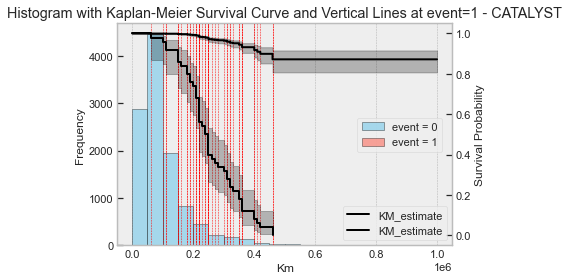

Median survival time (only ones):  240000.0 km


        KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.500              220000.000              270000.000


In [ ]:
###################################################################
##################### HISTOGRAM & KAPLAN MEIER ####################
###################################################################



from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.utils import qth_survival_times
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()
ax1.hist(X[X['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X[X['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
#ax1.legend(loc = "lower right")
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.6))


x_values = X[X['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
kmf = KaplanMeierFitter()
kmf.fit(X['km'], event_observed=X["event"])
kmf.plot_survival_function(ax=ax2, color='black')
ax2.set_ylabel('Survival Probability')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X[X.event == 1].copy()
kmf2 = KaplanMeierFitter()
kmf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
kmf2.plot_survival_function(ax=ax2, color='black')
ax2.set_ylabel('Survival Probability')
ax2.legend(loc = "lower right")





plt.title('Histogram with Kaplan-Meier Survival Curve and Vertical Lines at event=1 - CATALYST')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()



median_ = kmf2.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf2.confidence_interval_)
print("Median survival time (only ones): ", median_, "km")
print("\n\n", median_confidence_interval_)


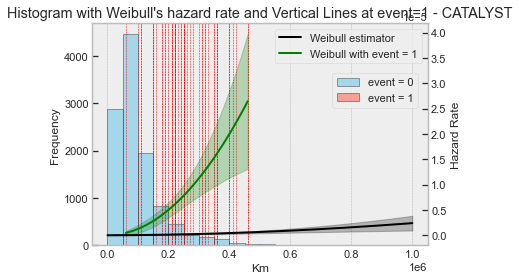

In [ ]:
###################################################################
######################## WEIBULL MODEL ############################
###################################################################


from lifelines import WeibullFitter


fig, ax1 = plt.subplots()
ax1.hist(X[X['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X[X['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.8))


x_values = X[X['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
wf = WeibullFitter()
wf.fit(X['km'], event_observed=X["event"])
wf.plot_hazard(ax=ax2, color='black', label = "Weibull estimator")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X[X.event == 1].copy()
wf2 = WeibullFitter()
wf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
wf2.plot_hazard(ax=ax2, color='green', label = "Weibull with event = 1")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "upper right")




plt.title('Histogram with Weibull\'s hazard rate and Vertical Lines at event=1 - CATALYST')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()


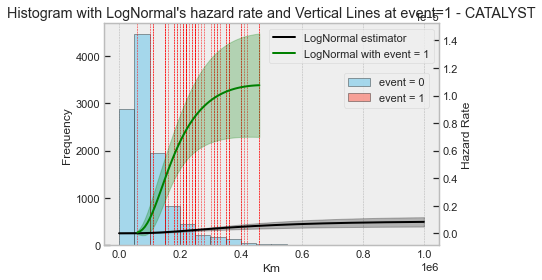

In [ ]:
###################################################################
######################## LOGNORMAL MODEL ##########################
###################################################################


from lifelines import LogNormalFitter

#### Often used when the logarithm of the survival times follows a normal distributio ####

fig, ax1 = plt.subplots()
ax1.hist(X[X['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X[X['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.8))


x_values = X[X['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
lnf = LogNormalFitter()
lnf.fit(X['km'], event_observed=X["event"])
lnf.plot_hazard(ax=ax2, color='black', label = "LogNormal estimator")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X[X.event == 1].copy()
lnf2 = LogNormalFitter()
lnf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
lnf2.plot_hazard(ax=ax2, color='green', label = "LogNormal with event = 1")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "upper right")




plt.title('Histogram with LogNormal\'s hazard rate and Vertical Lines at event=1 - CATALYST')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()


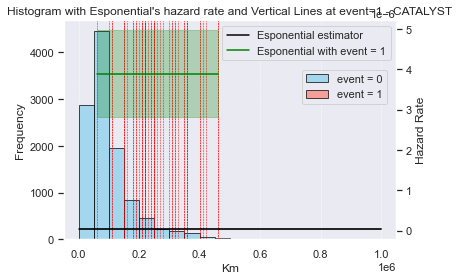

In [34]:
###################################################################
######################## EXPONENTIAL MODEL ########################
###################################################################


from lifelines import ExponentialFitter

fig, ax1 = plt.subplots()
ax1.hist(X[X['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X[X['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.8))


x_values = X[X['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
epf = ExponentialFitter()
epf.fit(X['km'], event_observed=X["event"])
epf.plot_hazard(ax=ax2, color='black', label = "Esponential estimator")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X[X.event == 1].copy()
epf2 = ExponentialFitter()
epf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
epf2.plot_hazard(ax=ax2, color='green', label = "Esponential with event = 1")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "upper right")




plt.title('Histogram with Esponential\'s hazard rate and Vertical Lines at event=1 - CATALYST')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()


'survival_function_predictions': function that takes care of creating a dataset with 2 records (one for each contract_market value) with their survival functions associated with specific mileage.

'survival_function_predictions': same thing, but specific to cox

'linear_interpolation': linear interpolation of values

### Functions

In [13]:
# PREDICTIONS
def survival_function_predictions(X, model):
    X_ = X.drop(columns=["unique_vehicle_id", "km", "mis", "part_number"])
    X_0 = X[X.event==0].reset_index()

    max_km = X_0.km_12.max()   # for this dataset, the max is 1.6M km


    TIME_BINS = np.arange(0, max_km + 50000, 50000, dtype="int")
    df = model.predict_survival_function(X_[X_.event == 0], times=TIME_BINS).T.reset_index(drop = True)

    df2 = df.copy()
    df2.insert(0, "unique_vehicle_id", X_0.unique_vehicle_id)
    df2.insert(1, "km", X_0.km)
    df2.insert(2, "km_12", X_0.km_12)
    df2.insert(3, "contract", X_0.contract_market)
    df2.insert(4, "mis", X_0.mis)
    df2.insert(5, "mis_plus_12", 0)
    df2.insert(6, "failure_flag_80", 0)
    df2.insert(7, "failure_flag_70", 0)
    df2.insert(8, "failure_flag_60", 0)
    df2.insert(9, "failure_flag_50", 0)
    df2.insert(10, "failure_flag_40", 0)
    df2.insert(11, "failure_flag_30", 0)
    df2.insert(12, "failure_flag_20", 0)




    # ADJUSTING THE DATASET, SUCH THAT WE CAN WORK WITH IT
    new_row = pd.Series(df.columns).to_frame().T
    new_row.columns = df.columns
    working_df = pd.concat([new_row, df], ignore_index=True)
    working_df = working_df.drop_duplicates().copy()


    return df2, df, working_df, TIME_BINS    # with and without additional columns + working_df + TIME_BINS


In [14]:
# PREDICTIONS
def survival_function_predictions_cox(X, model):
    X_ = X.drop(columns=["unique_vehicle_id", "km", "mis", "part_number"])
    X_0 = X[X.event==0].reset_index()

    # max_km = X_0.km_12.max()   # for this dataset, the max is 1.6M km


    TIME_BINS = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 460000, 510000, 560000, 610000, 660000,
            710000, 760000, 810000, 860000, 910000, 960000, 1010000, 1060000, 1110000, 1160000, 1210000, 1260000,
            1310000, 1360000, 1410000, 1460000, 1510000, 1560000, 1610000]

    # Predictions
    df = model.predict_survival_function(X_[X_.event == 0], times=TIME_BINS).T.reset_index(drop = True)

    df2 = df.copy()
    df2.insert(0, "unique_vehicle_id", X_0.unique_vehicle_id)
    df2.insert(1, "km", X_0.km)
    df2.insert(2, "km_12", X_0.km_12)
    df2.insert(3, "contract", X_0.contract_market)
    df2.insert(4, "mis", X_0.mis)
    df2.insert(5, "mis_plus_12", 0)
    df2.insert(6, "failure_flag_80", 0)
    df2.insert(7, "failure_flag_70", 0)
    df2.insert(8, "failure_flag_60", 0)
    df2.insert(9, "failure_flag_50", 0)
    df2.insert(10, "failure_flag_40", 0)
    df2.insert(11, "failure_flag_30", 0)
    df2.insert(12, "failure_flag_20", 0)




    # ADJUSTING THE DATASET, SUCH THAT WE CAN WORK WITH IT
    new_row = pd.Series(df.columns).to_frame().T
    new_row.columns = df.columns
    working_df = pd.concat([new_row, df], ignore_index=True)
    working_df = working_df.drop_duplicates().copy()


    return df2, df, working_df, TIME_BINS    # with and without additional columns + working_df + TIME_BINS


In [15]:
# LINEAR INTERPOLATION:

def linear_interpolation(working_df, df2):
    
    i = 0
    for km in df2.km_12:

        # Contract = FRANCE
        if df2.loc[i, "contract"] == 1:
            flag = 1
            index = 1
            while flag != 0:

                if working_df.iloc[0, index] > km:
                    prob_delta = working_df.iloc[1, index - 1] - working_df.iloc[1, index]
                    range_diff = working_df.iloc[0, index] - working_df.iloc[0, index-1]
                    km_diff = km - working_df.iloc[0, index - 1]

                    # Linear probability interpolation
                    x = (prob_delta * km_diff) / range_diff
                    df2.loc[i, "mis_plus_12"] = working_df.iloc[1, index - 1] - x


                    # Quick (approximate) check: (the new probabality has to be greater than the upper bound)
                    if df2.loc[i, "mis_plus_12"] < working_df.iloc[1, index]:
                        print(f"ERROR at index {i}")
                        return
                        
                    # Out of the loop
                    flag = 0

                index = index + 1


        # CONTRACT != FRANCE
        else:
            flag = 1
            index = 1               ################ EDITED (previous was index = 2) ################
            while flag != 0:

                if working_df.iloc[0, index] > km:
                    prob_delta = working_df.iloc[2, index - 1] - working_df.iloc[2, index]
                    range_diff = working_df.iloc[0, index] - working_df.iloc[0, index-1]
                    km_diff = km - working_df.iloc[0, index - 1]

                    # Linear probability interpolation
                    x = (prob_delta * km_diff) / range_diff
                    df2.loc[i, "mis_plus_12"] = working_df.iloc[2, index - 1] - x


                    # Quick (approximate) check: (the new probabality has to be greater than the upper bound)
                    if df2.loc[i, "mis_plus_12"] < working_df.iloc[2, index]:
                        print(f"ERROR at index {i}")
                        return

                    # Out of the loop
                    flag = 0


                index = index + 1                   



        i = i + 1


    # THRESHOLD (< X% = broken)
    df2.loc[:, "failure_flag_80"] = np.where(df2.loc[:, "mis_plus_12"] < 0.8, 1, 0)
    df2.loc[:, "failure_flag_70"] = np.where(df2.loc[:, "mis_plus_12"] < 0.7, 1, 0)
    df2.loc[:, "failure_flag_60"] = np.where(df2.loc[:, "mis_plus_12"] < 0.6, 1, 0)
    df2.loc[:, "failure_flag_50"] = np.where(df2.loc[:, "mis_plus_12"] < 0.5, 1, 0)
    df2.loc[:, "failure_flag_40"] = np.where(df2.loc[:, "mis_plus_12"] < 0.4, 1, 0)
    df2.loc[:, "failure_flag_30"] = np.where(df2.loc[:, "mis_plus_12"] < 0.3, 1, 0)
    df2.loc[:, "failure_flag_20"] = np.where(df2.loc[:, "mis_plus_12"] < 0.2, 1, 0)


    return df2


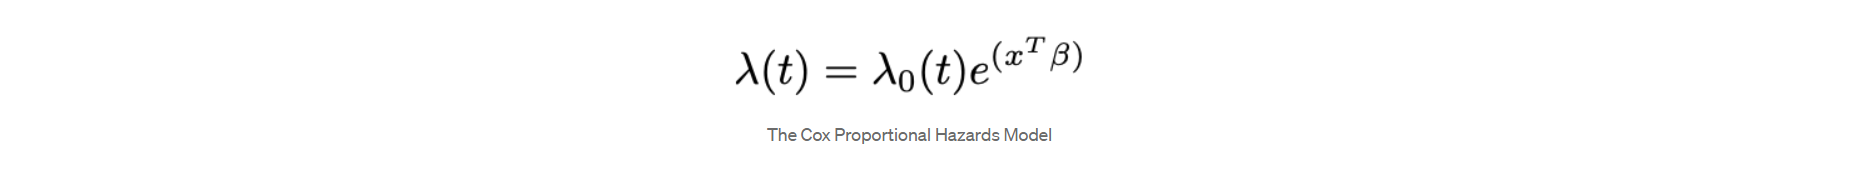

<lifelines.CoxPHFitter: fitted with 11266 total observations, 11216 right-censored observations>
             duration col = 'km'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 11266
number of events observed = 50
   partial log-likelihood = -307.05
         time fit was run = 2024-06-27 13:17:36 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
contract_market   1.68       5.37       0.33             1.03             2.34                 2.79                10.35

                  cmp to    z      p   -log2(p)
covariate                                      
contract_market     0.00 5.03 <0.005      20.93
---
Concordance = 0.64
Partial AIC = 616.11
log-likelihood ratio test = 30.44 on 1 df
-log2(p) of ll-ratio test = 24.79

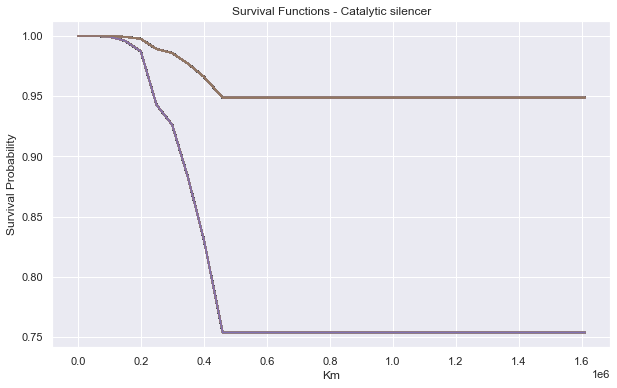

In [16]:
###################################################################
############################ COX-PH MODEL #########################
###################################################################

# Here we are interested in understanding the effect of the covariate on the HAZARD RATE
# No functional assumptions are made about the shape of the Hazard Function;
# instead, functional-form assumptions are made about the effects of the covariates alone.

# Regardless of the values covariates, all subjects share the same baseline hazard λₒ.
# (thereafter, adjustments are made based on the covariates)


from lifelines import CoxPHFitter


cph_c = CoxPHFitter()

X_c = X.drop(columns=["unique_vehicle_id", "km_12", "mis", "part_number"])
cph_c.fit(X_c, duration_col='km', event_col='event', formula = "contract_market")

cph_c.print_summary()


TIME_BINS = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 460000, 510000, 560000, 610000, 660000,
            710000, 760000, 810000, 860000, 910000, 960000, 1010000, 1060000, 1110000, 1160000, 1210000, 1260000,
            1310000, 1360000, 1410000, 1460000, 1510000, 1560000, 1610000]


survival_predictions_cox = cph_c.predict_survival_function(X_c[X_c.event==0], times=TIME_BINS)

# Plot the survival functions
plt.figure(figsize=(10, 6))
for i in range(survival_predictions_cox.shape[1]):
    plt.plot(survival_predictions_cox.index, survival_predictions_cox.iloc[:, i], label=f'Observation {i+1}')
plt.title('Survival Functions - Catalytic silencer')
plt.xlabel('Km')
plt.ylabel('Survival Probability')
plt.show()


**C-index** is a measurement of ordering: it checks if the model assigns higher risk to individuals that survived less, but not if the expected time or survival probabilities are calibrated and unbiased (just like AUC).

For instance, using 'survival:aft' as objective, we can tweak 'aft_loss_distribution_scale' and build models with very different average predicted survival times, while maintaing good C-indexes.

In [11]:
survival_predictions_cox.T.drop_duplicates()


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
0,1.000,1.000,0.999,0.996,0.987,0.943,0.926,0.883,0.831,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754
1,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949


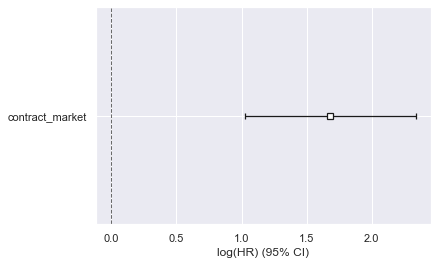

covariate
contract_market   1.682
Name: coef, dtype: float64


In [12]:
cph_c.plot()
plt.show()
print(cph_c.params_)


<AxesSubplot:>

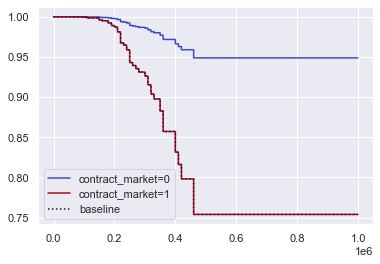

In [13]:
# What the survival curves look like as we vary a single covariate while holding everything else equal?

cph_c.plot_partial_effects_on_outcome(covariates='contract_market', values=[0, 1], cmap='coolwarm')


<AxesSubplot:>

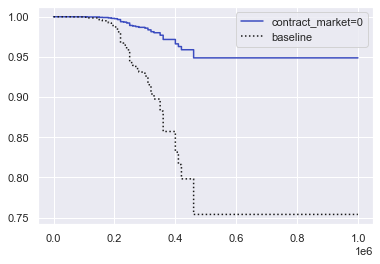

In [14]:
# What the survival curves look like as we vary a single covariate while holding everything else equal?

cph_c.plot_partial_effects_on_outcome(covariates='contract_market', values=[0], cmap='coolwarm')


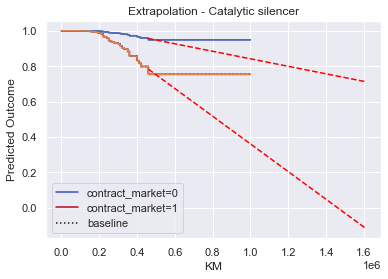

Contract market = 0 0.7122700615159749
Contract market = 1 -0.11559995479438667


In [17]:
############# (LINEAR) EXTRAPOLATION #############

# The curve stops at 460K km, since there are no more observations with event = 1
# In order to escape the lack of data, we could (linearly, in this case) EXTRAPOLATE

ax_c = cph_c.plot_partial_effects_on_outcome(covariates='contract_market', values=[0, 1], cmap='coolwarm')


# Data points from the plot contract_market = 0
lines = ax_c.get_lines()
x_data_0_c = lines[0].get_xdata()
y_data_0_c = lines[0].get_ydata()

# Data points from the plot contract_market = 1
x_data_1_c = lines[1].get_xdata()
y_data_1_c = lines[1].get_ydata()


# Range of interest (410K-460K in this case)
end_range_c = X[X.event==1].km.max()

# Data points in the range of interest
selected_indices_0_c = (x_data_0_c >= end_range_c - 20000) & (x_data_0_c <= end_range_c)
x_selected_0_c = x_data_0_c[selected_indices_0_c]
y_selected_0_c = y_data_0_c[selected_indices_0_c]

# contract_market = 1
selected_indices_1_c = (x_data_1_c >= end_range_c - 60000) & (x_data_1_c <= end_range_c)
x_selected_1_c = x_data_1_c[selected_indices_1_c]
y_selected_1_c = y_data_1_c[selected_indices_1_c]


# Linear fit
coefficients_0_c = np.polyfit(x_selected_0_c, y_selected_0_c, 1)
linear_model_0_c = np.poly1d(coefficients_0_c)

coefficients_1_c = np.polyfit(x_selected_1_c, y_selected_1_c, 1)
linear_model_1_c = np.poly1d(coefficients_1_c)


# New values for extrapolation
max_km_c = X[X.event==0].km_12.max() + 10000
x_new_c = np.arange(end_range_c, max_km_c, 50000)
y_new_0_c = linear_model_0_c(x_new_c)
y_new_1_c = linear_model_1_c(x_new_c)



plt.plot(x_data_0_c, y_data_0_c, label='Original Data')
plt.plot(x_new_c, y_new_0_c, '--', label='Extrapolated Data', color='red')
plt.plot(x_data_1_c, y_data_1_c, label='Original Data')
plt.plot(x_new_c, y_new_1_c, '--', label='Extrapolated Data', color='red')
plt.xlabel('KM')
plt.ylabel('Predicted Outcome')
plt.title("Extrapolation - Catalytic silencer")

plt.show()


# Probabilities at the last km (mis + 12)
print("Contract market = 0", y_new_0_c.min())
print("Contract market = 1", y_new_1_c.min())



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 11266 total observations, 11216 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic      p  -log2(p)
contract_market km              8.57 <0.005      8.19
                rank            3.43   0.06      3.96



1. Variable 'contract_market' failed the non-proportional test: p-value is 0.0034.

   Advice: with so few unique values (only 2), you can include `strata=['contract_market', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.0641)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0034)'>]]

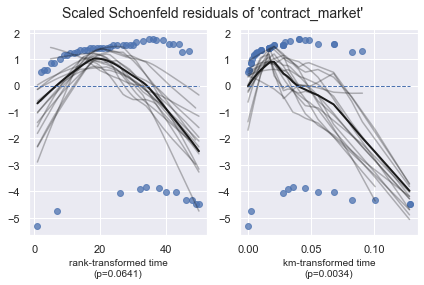

In [18]:
# Checking the proportional hazard assumption:
# (when using the Cox model, we are implicitly applying the proportional hazard assumption)

cph_c.check_assumptions(X, p_value_threshold=0.05, show_plots=True)


In [19]:
print(y_new_0_c.shape)
print(y_new_1_c.shape)
print(survival_predictions_cox.T.drop_duplicates().shape)


(24,)
(24,)
(2, 33)


In [20]:
# It is flatten since we did not perform extrapolation yet
survival_predictions_cox.T.drop_duplicates()


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
0,1.000,1.000,0.999,0.996,0.987,0.943,0.926,0.883,0.831,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754
1,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949


In [21]:
cox_working_df_c = survival_predictions_cox.T.drop_duplicates().copy()
cox_working_df_c.iloc[0, 9:] = y_new_1_c
cox_working_df_c.iloc[1, 9:] = y_new_0_c

new_row_c = pd.Series(cox_working_df_c.columns).to_frame().T
new_row_c.columns = cox_working_df_c.columns
cox_working_df_c = pd.concat([new_row_c, cox_working_df_c], ignore_index=True)


In [22]:
cox_working_df_c


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
0,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
1,1.000,1.000,0.999,0.996,0.987,0.943,0.926,0.883,0.831,0.783,0.744,0.705,0.666,0.627,0.588,0.549,0.510,0.471,0.432,0.392,0.353,0.314,0.275,0.236,0.197,0.158,0.119,0.080,0.041,0.002,-0.037,-0.077,-0.116
2,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.956,0.946,0.935,0.924,0.914,0.903,0.893,0.882,0.871,0.861,0.850,0.840,0.829,0.818,0.808,0.797,0.787,0.776,0.765,0.755,0.744,0.733,0.723,0.712


In [23]:
#### FUNCTION 1 ####
df2_c, df_c, working_df_c, TIME_BINS_c = survival_function_predictions_cox(X, cph_c)


In [25]:
df_c.head()


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
0,1.000,1.000,0.999,0.996,0.987,0.943,0.926,0.883,0.831,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754,0.754
1,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949
2,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949
3,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949
4,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949,0.949


In [26]:
# Filling df2
for idx in range(len(df2_c)):
    if df2_c.loc[idx, "contract"]==1:
        df2_c.iloc[idx, 13:] = cox_working_df_c.iloc[1, :].values
    else:
        df2_c.iloc[idx, 13:] = cox_working_df_c.iloc[2, :].values


In [27]:
# Filling df
for idx in range(len(df_c)):
    if np.isclose(df_c.iloc[idx, -1], 0.712, atol=0.001):
        df_c.iloc[idx, :] = cox_working_df_c.iloc[1, :].values
    else:
        df_c.iloc[idx, :] = cox_working_df_c.iloc[2, :].values


In [29]:
df_c.drop_duplicates()


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
0,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.956,0.946,0.935,0.924,0.914,0.903,0.893,0.882,0.871,0.861,0.850,0.840,0.829,0.818,0.808,0.797,0.787,0.776,0.765,0.755,0.744,0.733,0.723,0.712


In [30]:
# Given the fact that the model has just the variable "contract_market" to discriminate,
# it calculates only to groups (since the variable can be 1 or 0)
df2_c.drop(columns=["unique_vehicle_id", "km", "km_12", "mis", "mis_plus_12", "failure_flag_80",
                "failure_flag_70", "failure_flag_60", "failure_flag_50", "failure_flag_40",
                "failure_flag_30", "failure_flag_20"]).drop_duplicates()


# Interpretation: groups with "FRANCE" as market are more likely to exeperience failures


,contract,0.0,50000.0,100000.0,150000.0,200000.0,250000.0,300000.0,350000.0,400000.0,460000.0,510000.0,560000.0,610000.0,660000.0,710000.0,760000.0,810000.0,860000.0,910000.0,960000.0,1010000.0,1060000.0,1110000.0,1160000.0,1210000.0,1260000.0,1310000.0,1360000.0,1410000.0,1460000.0,1510000.0,1560000.0,1610000.0
0,1,1.000,1.000,0.999,0.996,0.987,0.943,0.926,0.883,0.831,0.783,0.744,0.705,0.666,0.627,0.588,0.549,0.510,0.471,0.432,0.392,0.353,0.314,0.275,0.236,0.197,0.158,0.119,0.080,0.041,0.002,-0.037,-0.077,-0.116
1,0,1.000,1.000,1.000,0.999,0.998,0.989,0.986,0.977,0.966,0.956,0.946,0.935,0.924,0.914,0.903,0.893,0.882,0.871,0.861,0.850,0.840,0.829,0.818,0.808,0.797,0.787,0.776,0.765,0.755,0.744,0.733,0.723,0.712


In [31]:
##### FUNCTION 2 #####

# PREDICTION MIS + 12  (INTERPOLATION)
df2_c_ = linear_interpolation(cox_working_df_c, df2_c)


In [32]:
df2_c_[["failure_flag_80", "failure_flag_70", "failure_flag_60", "failure_flag_50",
      "failure_flag_40", "failure_flag_30", "failure_flag_20"]].apply(pd.Series.value_counts)


,failure_flag_80,failure_flag_70,failure_flag_60,failure_flag_50,failure_flag_40,failure_flag_30,failure_flag_20
0,11130,11175,11184,11196,11199,11202,11205
1,86,41,32,20,17,14,11


In [35]:
###################################################################
############################ AFT MODEL ############################
###################################################################

from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter

wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
np.random.seed(42)
for model in [wb, ex, log, loglogis]:
    model.fit(durations = X["km"], event_observed = X["event"])

# Print AIC
print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)


The AIC value for LogLogisticFitter is 1666.5342572553152


In [36]:
# Implementation of the LogLogistic AFT Fitter
from lifelines import LogLogisticAFTFitter

np.random.seed(0)
aft_c = LogLogisticAFTFitter()

# Fit the model to the dataset
X_ = X.drop(columns=["unique_vehicle_id", "km_12", "mis", "part_number"])
aft_c.fit_right_censoring(X_, duration_col='km', event_col='event', formula = "contract_market",
                          show_progress=True)

aft_c.print_summary()
print("\n\nMEDIAN SURVIVAL TIME:", aft_c.median_survival_time_)
print("MEAN SURVIVAL TIME", aft_c.mean_survival_time_)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07296586857537218
            Iterations: 21
            Function evaluations: 23
            Gradient evaluations: 21
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.07296586857537218
       x: [ 1.399e+01 -1.723e-01  1.172e+00]
     nit: 21
     jac: [ 5.667e-05  8.563e-05  7.059e-05]
    nfev: 23
    njev: 21


<lifelines.LogLogisticAFTFitter: fitted with 11266 total observations, 11216 right-censored observations>
             duration col = 'km'
                event col = 'event'
   number of observations = 11266
number of events observed = 50
           log-likelihood = -822.03
         time fit was run = 2024-06-27 13:42:07 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                               
alpha_ Intercept        13.99   1.19e+06       0.12            13.74            14.23             9.30e+05             1.51e+06
       contract_market  -0.43       0.65       0.11            -0.64            -0.22                 0.53                 0.80
beta_  Intercept         1.17       3.23       0.07             1.04             1.31                 2.82                 3.70

                         cmp to      z      p   -log2(p)
param  covariate                                        
alpha_ Intercept           0.00 112.43 <0.005        inf
       contract_market     0.00  -4.01 <0.005      13.99
beta_  Intercept           0.00  17.06 <0.005     214.40
---
Concordance = 0.64
AIC = 1650.07
log-likelihood ratio test = 18.47 on 1 df
-log2(p) of ll-ratio test = 15.82



MEDIAN SURVIVAL TIME: 771645.0856039849
MEAN SURVIVAL TIME 908261.6513899018


In [37]:
# CROSS VALIDATION
from lifelines.utils import k_fold_cross_validation

# Concordance index by default
scores = k_fold_cross_validation(aft_c, X_, 'km', event_col='event', k=3)
print(scores)


[-0.07482886800859888, -0.07093793835957712, -0.07427543522505571]


# Interpretation of the coefficients

- A unit increase in $x_i$ means the average/median survival time changes by a factor of $exp(b_i)$
- A positive $b_i$ means a factor $exp(b_i)$ grater than 1, which will decelerate the event time (since we divide the time by the factor) ==> increase mean/median survival
- A negative $b_i$ ==> reduce the mean/median survival time
- Intercept: This is the baseline value of the log-duration when all covariates are 0. Its value is 1.17, and it can be interpreted as the log-duration for the baseline group.
- Exponential of Coefficients (exp(coef)):
These values represent the multiplicative effect on the duration time. In general, if the coefficient is positive, values greater than 1 imply that the event time is extended. If the coefficient is negative, values less than 1 imply that the event time is shortened. However, it is the opposite in lifelines.
- Standard Errors (se(coef)):
These values measure the variability or precision of the coefficient estimates. Smaller values indicate more precise estimates.
- z-values (z):
These are the statistics used to test the null hypothesis that a coefficient equals zero. A larger absolute value of z suggests a more significant effect of the covariate.
Both coefficients here have large absolute z-values, indicating strong effects.


**C-index** is a measurement of ordering: it checks if the model assigns higher risk to individuals that survived less, but not if the expected time or survival probabilities are calibrated and unbiased (just like AUC).

For instance, using 'survival:aft' as objective, we can tweak 'aft_loss_distribution_scale' and build models with very different average predicted survival times, while maintaing good C-indexes.

<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

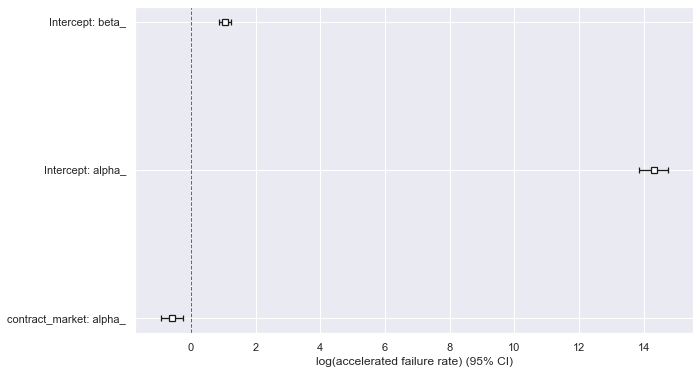

In [38]:
# FOREST PLOT (all covariates)
plt.subplots(figsize=(10, 6))
aft_c.plot()



# y-axis => list of the covariates (from the most significant (top) to the least significant)
# x-axis => coefficients estimated for each covariate


Text(0, 0.5, 'Survival probability')

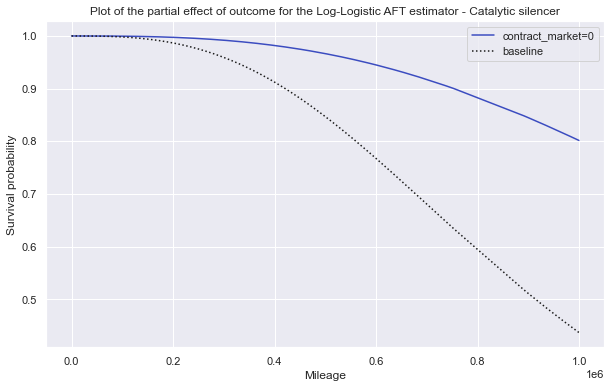

In [39]:
# HOW DOES SURVIVAL CHANGE WHEN WE CHANGE THE VALUES OF THE COVARIATES?
# (only contract_marketin in this case)
plt.subplots(figsize=(10, 6))
aft_c.plot_partial_effects_on_outcome("contract_market",
                                        range(0, 1),
                                        cmap='coolwarm')

plt.title("Plot of the partial effect of outcome for the Log-Logistic AFT estimator - Catalytic silencer")
plt.xlabel('Mileage')
plt.ylabel('Survival probability')


In [40]:
# PREDICTION OF THE SURVIVAL FUNCTION
# Given a new subject, we’d like to ask questions about their future survival. When are they likely to experience the event?

# This function simply returns the survival prediction at mis + 12 (for the max value)
df2_aft_c, df_aft_c, working_df_aft_c, TIME_BINS_c = survival_function_predictions(X, aft_c)


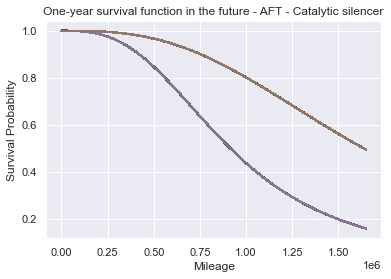

In [41]:
# PLOTTING THE SURVIVAL FUNCTION (one year in the future)
surv_func = aft_c.predict_survival_function(X_[X_.event == 0], times=TIME_BINS_c)
surv_func.plot(legend=False)

plt.title('One-year survival function in the future - AFT - Catalytic silencer')
plt.xlabel('Mileage')
plt.ylabel('Survival Probability')
plt.show()


In [42]:
# Given the fact that the model has just the variable "contract_market" to discriminate,
# it calculates only to groups (since the variable can be 1 or 0)
df2_aft_c.drop(columns=["unique_vehicle_id", "km", "km_12", "mis", "mis_plus_12", "failure_flag_80",
                "failure_flag_70", "failure_flag_60", "failure_flag_50", "failure_flag_40",
                "failure_flag_30", "failure_flag_20"]).drop_duplicates()


# Interpretation: groups with "FRANCE" as market are more likely to exeperience failures


,contract,0.0,50000.0,100000.0,150000.0,200000.0,250000.0,300000.0,350000.0,400000.0,450000.0,500000.0,550000.0,600000.0,650000.0,700000.0,750000.0,800000.0,850000.0,900000.0,950000.0,1000000.0,1050000.0,1100000.0,1150000.0,1200000.0,1250000.0,1300000.0,1350000.0,1400000.0,1450000.0,1500000.0,1550000.0,1600000.0,1650000.0
0,1,1.000,1.000,0.998,0.994,0.987,0.975,0.959,0.938,0.912,0.882,0.847,0.808,0.767,0.724,0.681,0.637,0.593,0.551,0.511,0.473,0.437,0.403,0.372,0.343,0.316,0.292,0.269,0.249,0.230,0.213,0.197,0.183,0.170,0.158
1,0,1.000,1.000,1.000,0.999,0.997,0.995,0.992,0.988,0.982,0.975,0.966,0.956,0.945,0.932,0.917,0.901,0.884,0.865,0.845,0.824,0.802,0.779,0.755,0.731,0.707,0.682,0.658,0.633,0.609,0.585,0.561,0.538,0.516,0.494


In [43]:
df_aft_c.head()


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,450000.000,500000.000,550000.000,600000.000,650000.000,700000.000,750000.000,800000.000,850000.000,900000.000,950000.000,1000000.000,1050000.000,1100000.000,1150000.000,1200000.000,1250000.000,1300000.000,1350000.000,1400000.000,1450000.000,1500000.000,1550000.000,1600000.000,1650000.000
0,1.000,1.000,0.998,0.994,0.987,0.975,0.959,0.938,0.912,0.882,0.847,0.808,0.767,0.724,0.681,0.637,0.593,0.551,0.511,0.473,0.437,0.403,0.372,0.343,0.316,0.292,0.269,0.249,0.230,0.213,0.197,0.183,0.170,0.158
1,1.000,1.000,1.000,0.999,0.997,0.995,0.992,0.988,0.982,0.975,0.966,0.956,0.945,0.932,0.917,0.901,0.884,0.865,0.845,0.824,0.802,0.779,0.755,0.731,0.707,0.682,0.658,0.633,0.609,0.585,0.561,0.538,0.516,0.494
2,1.000,1.000,1.000,0.999,0.997,0.995,0.992,0.988,0.982,0.975,0.966,0.956,0.945,0.932,0.917,0.901,0.884,0.865,0.845,0.824,0.802,0.779,0.755,0.731,0.707,0.682,0.658,0.633,0.609,0.585,0.561,0.538,0.516,0.494
3,1.000,1.000,1.000,0.999,0.997,0.995,0.992,0.988,0.982,0.975,0.966,0.956,0.945,0.932,0.917,0.901,0.884,0.865,0.845,0.824,0.802,0.779,0.755,0.731,0.707,0.682,0.658,0.633,0.609,0.585,0.561,0.538,0.516,0.494
4,1.000,1.000,1.000,0.999,0.997,0.995,0.992,0.988,0.982,0.975,0.966,0.956,0.945,0.932,0.917,0.901,0.884,0.865,0.845,0.824,0.802,0.779,0.755,0.731,0.707,0.682,0.658,0.633,0.609,0.585,0.561,0.538,0.516,0.494


In [44]:
working_df_aft_c


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,450000.000,500000.000,550000.000,600000.000,650000.000,700000.000,750000.000,800000.000,850000.000,900000.000,950000.000,1000000.000,1050000.000,1100000.000,1150000.000,1200000.000,1250000.000,1300000.000,1350000.000,1400000.000,1450000.000,1500000.000,1550000.000,1600000.000,1650000.000
0,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,450000.000,500000.000,550000.000,600000.000,650000.000,700000.000,750000.000,800000.000,850000.000,900000.000,950000.000,1000000.000,1050000.000,1100000.000,1150000.000,1200000.000,1250000.000,1300000.000,1350000.000,1400000.000,1450000.000,1500000.000,1550000.000,1600000.000,1650000.000
1,1.000,1.000,0.998,0.994,0.987,0.975,0.959,0.938,0.912,0.882,0.847,0.808,0.767,0.724,0.681,0.637,0.593,0.551,0.511,0.473,0.437,0.403,0.372,0.343,0.316,0.292,0.269,0.249,0.230,0.213,0.197,0.183,0.170,0.158
2,1.000,1.000,1.000,0.999,0.997,0.995,0.992,0.988,0.982,0.975,0.966,0.956,0.945,0.932,0.917,0.901,0.884,0.865,0.845,0.824,0.802,0.779,0.755,0.731,0.707,0.682,0.658,0.633,0.609,0.585,0.561,0.538,0.516,0.494


In [45]:
# PREDICTION MIS + 12
df2_aft_c_ = linear_interpolation(working_df_aft_c, df2_aft_c)


In [46]:
df2_aft_c_[["failure_flag_80", "failure_flag_70", "failure_flag_60", "failure_flag_50",
      "failure_flag_40", "failure_flag_30", "failure_flag_20"]].apply(pd.Series.value_counts)


,failure_flag_80,failure_flag_70,failure_flag_60,failure_flag_50,failure_flag_40,failure_flag_30,failure_flag_20
0,11175,11183,11194,11199,11202,11206,11213
1,41,33,22,17,14,10,3


In [47]:
# Alternatively
df2_aft_c_[["failure_flag_80", "failure_flag_70", "failure_flag_60", "failure_flag_50",
      "failure_flag_40", "failure_flag_30", "failure_flag_20"]].apply(lambda x: (x == 1).sum()).to_frame().T


,failure_flag_80,failure_flag_70,failure_flag_60,failure_flag_50,failure_flag_40,failure_flag_30,failure_flag_20
0,41,33,22,17,14,10,3


In [48]:
###################################################################
###################### XBGSE (debiased) MODEL #####################
###################################################################

from xgbse import XGBSEDebiasedBCE
from xgbse.converters import convert_to_structured
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.metrics import make_scorer
from xgbse.metrics import (concordance_index, approx_brier_score)
from xgbse.extrapolation import extrapolate_constant_risk
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display

 
# Better plots
set_matplotlib_formats('retina')
plt.style.use('bmh')

# Reproducibility
np.random.seed(42)


TIME_BINS_c = [
    0, 60000, 120000, 180000, 240000, 300000, 360000, 460000, 600000, 720000, 840000, 950000
]
 
xgbse_model_c = XGBSEDebiasedBCE(
    xgb_params={
        "aft_loss_distribution": "normal",
        "aft_loss_distribution_scale": 0.5,
        "booster": "dart",
        "colsample_bynode": 0.8,
        "eval_metric": "aft-nloglik",
        "learning_rate": 0.05,
        "max_depth": 5,
        "min_child_weight": 1,
        "objective": "survival:aft",
        "subsample": 0.8,
        "tree_method": "hist",
    }
)


X_train_c = X["contract_market"]
y_train_c = convert_to_structured(X["km"], X["event"])

X_test_c = X[X.event == 0]["contract_market"]
y_test_c = convert_to_structured(X[X.event == 0]["km_12"], X[X.event == 0]["event"])


xgbse_model_c.fit(X_train_c, y_train_c, time_bins=TIME_BINS_c)
y_pred_c = xgbse_model_c.predict(X_test_c)


# Extrapolation of the survival probabilities beyond the observed data (460K km)
last_km_c = X[X.event==1].km.max()
y_pred_extrapolated_c = extrapolate_constant_risk(y_pred_c.loc[:, :last_km_c], 1650000, 50000)


Average Brier Score: 0.0301683180046509


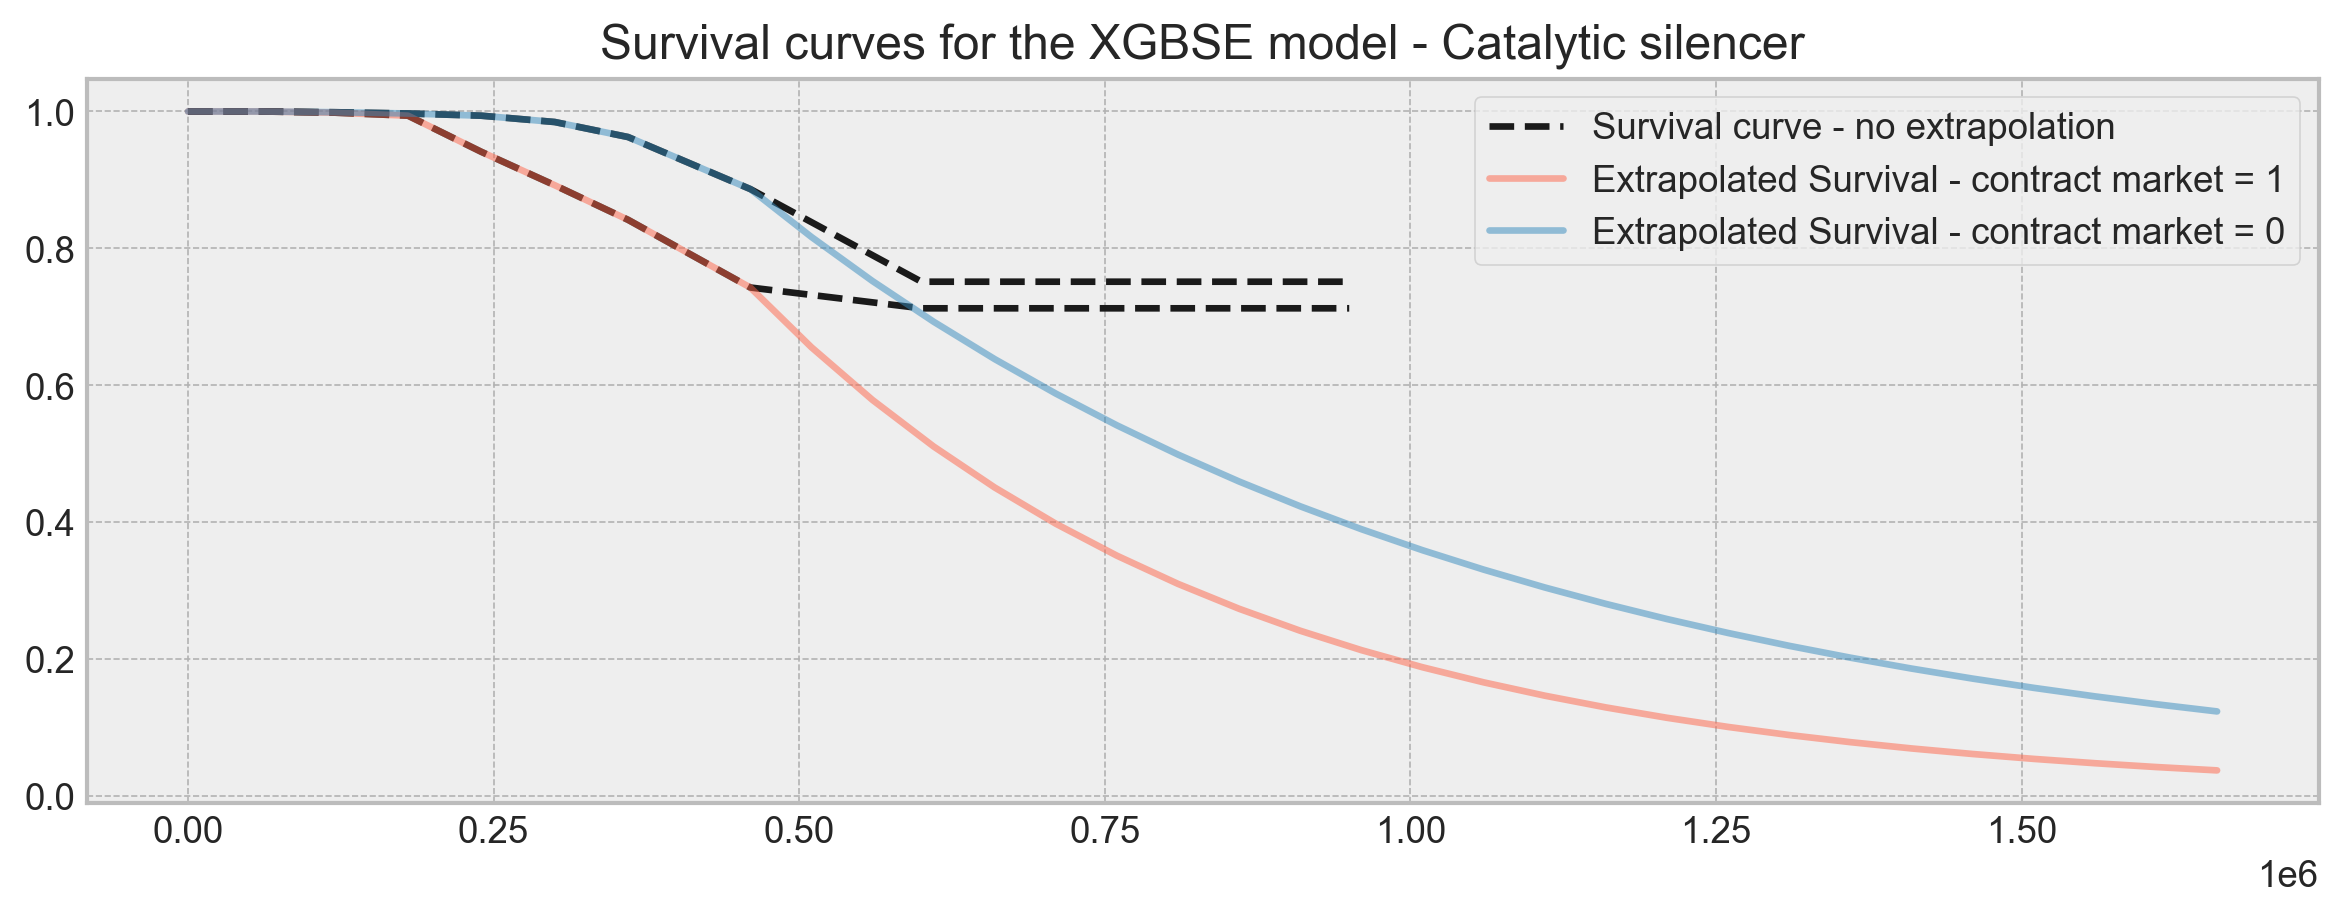

In [49]:
# plotting extrapolation
plt.figure(figsize=(12,4), dpi=120)
plt.plot(
    y_pred_c.columns,
    y_pred_c.iloc[0],
    'k--',
    label='Survival curve - no extrapolation'
)
plt.plot(
    y_pred_c.columns,
    y_pred_c.iloc[1],
    'k--'
)
plt.plot(
    y_pred_extrapolated_c.columns,
    y_pred_extrapolated_c.iloc[0],
    'tomato',
    alpha=0.5,
    label='Extrapolated Survival - contract market = 1'
)
plt.plot(
    y_pred_extrapolated_c.columns,
    y_pred_extrapolated_c.iloc[1],
    alpha=0.5,
    label='Extrapolated Survival - contract market = 0'
)
plt.title('Survival curves for the XGBSE model - Catalytic silencer')
plt.legend()


 
 
# Evaluation of model performances
bs = approx_brier_score(y_test_c, y_pred_c)
#ci = concordance_index(y_test, -y_pred, risk_strategy="precomputed")
#print(f'\n\nConcordance index: {ci}')
print(f'Average Brier Score: {bs}')

# Cross validation
#results = cross_val_score(xgbse_model, X, y_structured, scoring = make_scorer(approx_brier_score))
#print(f"Cross validation (Brier Score metric): {results}")


**Interpretation Brier Score:** th ebrier score is a way to verify the accuracy of a probability forecast. It ranges from 0 and 1, where 1 identifies the best possible score (total accuracy), and 0 the wrost possible score (wholly inaccurate).


FORMULA:

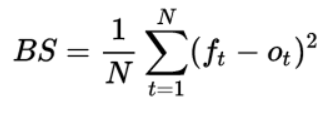


Where:

- N = number of items we are calculating a Brier score for.
- $f_t$ is the forecast probability
- $o_t$ is the outcome (1 if it happened, 0 if it didn't)

In [50]:
# Computing concordance index:
X_test = X["contract_market"]
y_true = convert_to_structured(X["km_12"], X["event"])

xgbse_model_c.fit(X_train_c, y_train_c, time_bins=TIME_BINS_c)
y_pred = xgbse_model_c.predict(X_test)

y_pred_extrapolated = extrapolate_constant_risk(y_pred.loc[:, :last_km_c], 1650000, 50000)


In [51]:
ci = concordance_index(y_true, y_pred_extrapolated, risk_strategy="mean")
print(f"The concordance index estimate is: {ci}")


The concordance index estimate is: 0.6492972419717434


In [52]:
# PREPARATION FOR THE XGBSE THRESHOLD DATASET
working_df_xgbse = y_pred_extrapolated_c.drop_duplicates().copy()
y_pred_extrapolated_c2 = y_pred_extrapolated_c.copy()

new_row = pd.Series(working_df_xgbse.columns).to_frame().T
new_row.columns = working_df_xgbse.columns
working_df_xgbse = pd.concat([new_row, working_df_xgbse], ignore_index=True)


y_pred_extrapolated_c2.insert(0, "unique_vehicle_id", 0)
y_pred_extrapolated_c2.insert(1, "km", 0)
y_pred_extrapolated_c2.insert(2, "mis", 0)
y_pred_extrapolated_c2.insert(3, "km_12", 0)
y_pred_extrapolated_c2.insert(4, "contract", 0)
y_pred_extrapolated_c2.insert(5, "mis_plus_12", 0)

y_pred_extrapolated_c2.insert(6, "failure_flag_80", 0)
y_pred_extrapolated_c2.insert(7, "failure_flag_70", 0)
y_pred_extrapolated_c2.insert(8, "failure_flag_60", 0)
y_pred_extrapolated_c2.insert(9, "failure_flag_50", 0)
y_pred_extrapolated_c2.insert(10, "failure_flag_40", 0)
y_pred_extrapolated_c2.insert(11, "failure_flag_30", 0)
y_pred_extrapolated_c2.insert(12, "failure_flag_20", 0)


np.random.seed(42)
y_pred_extrapolated_c2.loc[:, "contract"] = np.where(
    np.isclose(y_pred_extrapolated_c2.iloc[:, -1], 0.037, rtol=0, atol=.001),
    1, 0
)

y_pred_extrapolated_c2.loc[:, "unique_vehicle_id"] = X["unique_vehicle_id"].reset_index(drop=True)
y_pred_extrapolated_c2.loc[:, "km"] = X["km"].reset_index(drop=True)
y_pred_extrapolated_c2.loc[:, "mis"] = X["mis"].reset_index(drop=True)
y_pred_extrapolated_c2.loc[:, "km_12"] = y_pred_extrapolated_c2.loc[:, "km"] + y_pred_extrapolated_c2.loc[:, "km"] * 12 / y_pred_extrapolated_c2.loc[:, "mis"]


In [53]:
working_df_xgbse


,0,60000,120000,180000,240000,300000,360000,460000,510000,560000,610000,660000,710000,760000,810000,860000,910000,960000,1010000,1060000,1110000,1160000,1210000,1260000,1310000,1360000,1410000,1460000,1510000,1560000,1610000,1660000
0,0.000,60000.000,120000.000,180000.000,240000.000,300000.000,360000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000,1660000.000
1,1.000,1.000,0.998,0.994,0.941,0.892,0.842,0.743,0.655,0.578,0.510,0.450,0.397,0.351,0.309,0.273,0.241,0.213,0.188,0.166,0.146,0.129,0.114,0.100,0.089,0.078,0.069,0.061,0.054,0.047,0.042,0.037
2,1.000,1.000,0.999,0.997,0.994,0.985,0.963,0.887,0.817,0.752,0.693,0.638,0.588,0.541,0.498,0.459,0.423,0.389,0.359,0.330,0.304,0.280,0.258,0.238,0.219,0.202,0.186,0.171,0.158,0.145,0.134,0.123


In [55]:
# LINEAR INTERPOLATION
y_pred_extrapolated2_ = linear_interpolation(working_df_xgbse, y_pred_extrapolated_c2)


In [57]:
y_pred_extrapolated2_[["failure_flag_80", "failure_flag_70", "failure_flag_60", "failure_flag_50",
      "failure_flag_40", "failure_flag_30", "failure_flag_20"]].apply(pd.Series.value_counts)


,failure_flag_80,failure_flag_70,failure_flag_60,failure_flag_50,failure_flag_40,failure_flag_30,failure_flag_20
0,10886,11077,11137,11171,11187,11197,11201
1,330,139,79,45,29,19,15


# MODELS - Turbocharger

In [ ]:
# TURBOCHARGER
part_numbers_list = ['58xxxx27', '58xxxx15']
X_turbo = part_numbers_preprocessing(inconvenient_df, fleet_df, part_numbers_list)

# Errors
print(f"{len(X_turbo) - len(X_turbo[X_turbo.km < 1e6])} deleted")
X_turbo = X_turbo[X_turbo.km < 1e6]


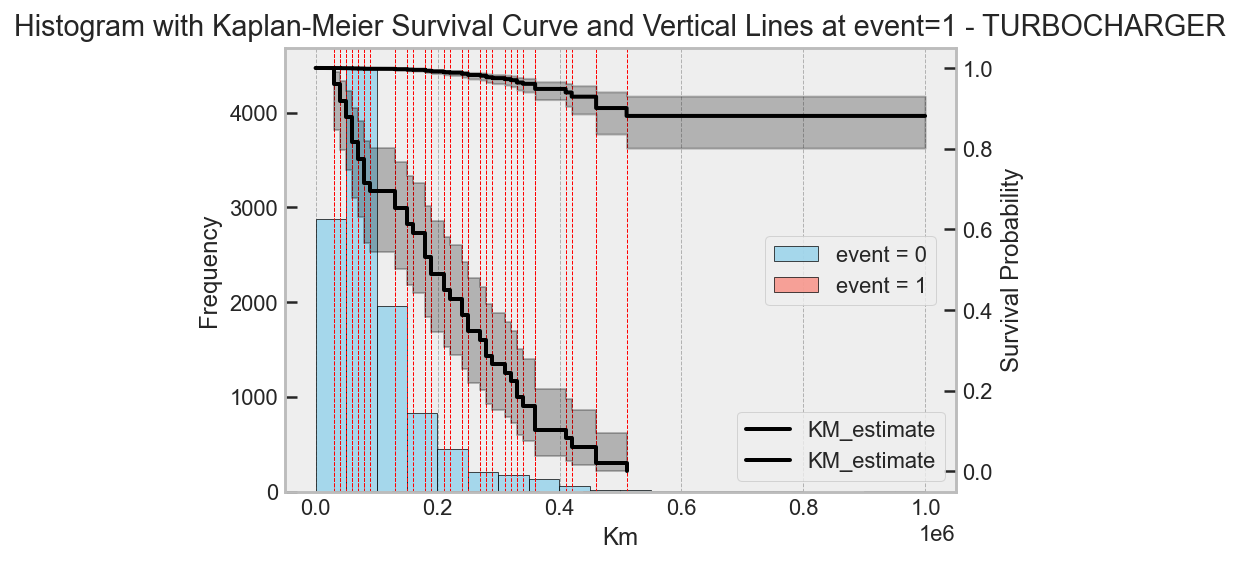

Median survival time (only ones):  190000.0 km


        KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.500              150000.000              250000.000


In [62]:
# HISTOGRAM & KAPLAN MEIER:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.utils import qth_survival_times
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()
ax1.hist(X_turbo[X_turbo['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X_turbo[X_turbo['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
#ax1.legend(loc = "lower right")
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.6))


x_values = X_turbo[X_turbo['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
kmf = KaplanMeierFitter()
kmf.fit(X_turbo['km'], event_observed=X_turbo["event"])
kmf.plot_survival_function(ax=ax2, color='black')
ax2.set_ylabel('Survival Probability')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X_turbo[X_turbo.event == 1].copy()
kmf2 = KaplanMeierFitter()
kmf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
kmf2.plot_survival_function(ax=ax2, color='black')
ax2.set_ylabel('Survival Probability')
ax2.legend(loc = "lower right")





plt.title('Histogram with Kaplan-Meier Survival Curve and Vertical Lines at event=1 - TURBOCHARGER')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()


median_ = kmf2.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf2.confidence_interval_)
print("Median survival time (only ones): ", median_, "km")
print("\n\n", median_confidence_interval_)


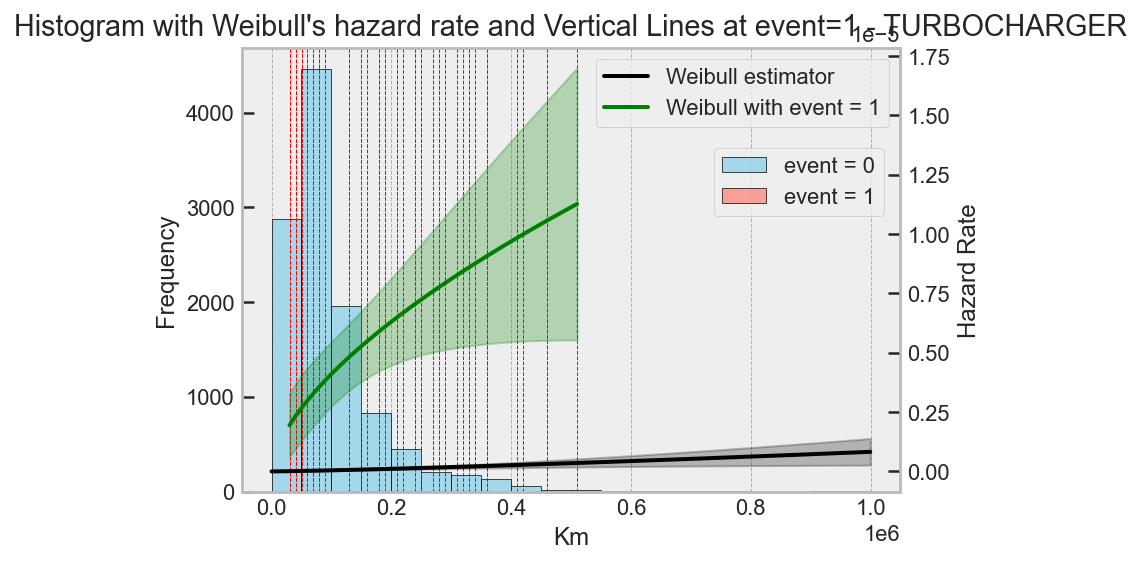

In [63]:
from lifelines import WeibullFitter


fig, ax1 = plt.subplots()
ax1.hist(X_turbo[X_turbo['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X_turbo[X_turbo['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.8))


x_values = X_turbo[X_turbo['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
wf = WeibullFitter()
wf.fit(X_turbo['km'], event_observed=X_turbo["event"])
wf.plot_hazard(ax=ax2, color='black', label = "Weibull estimator")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X_turbo[X_turbo.event == 1].copy()
wf2 = WeibullFitter()
wf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
wf2.plot_hazard(ax=ax2, color='green', label = "Weibull with event = 1")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "upper right")




plt.title('Histogram with Weibull\'s hazard rate and Vertical Lines at event=1 - TURBOCHARGER')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()


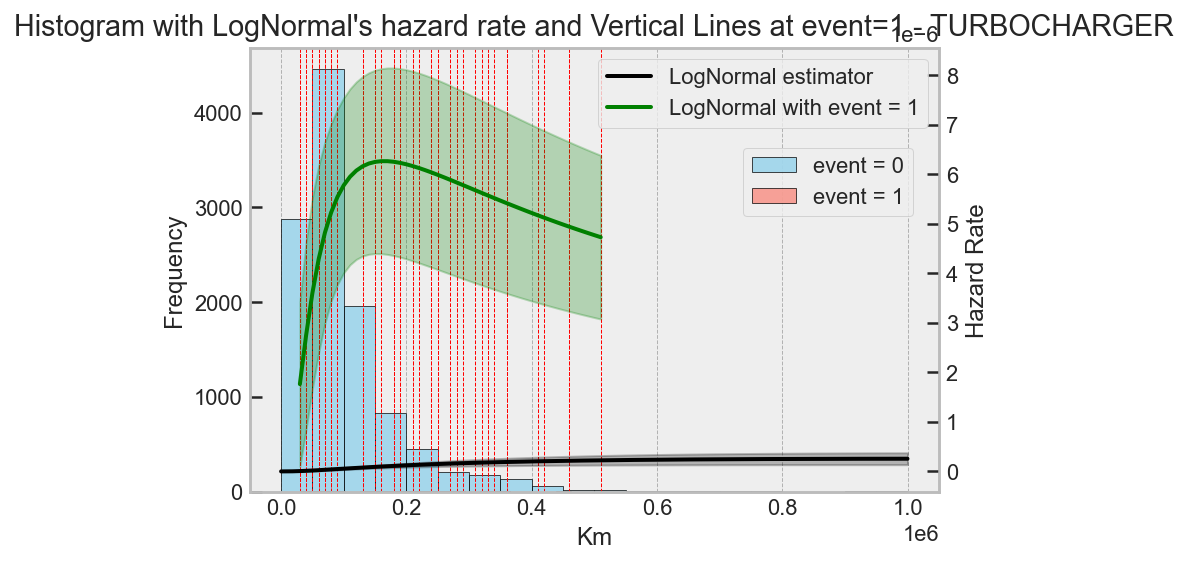

In [64]:
from lifelines import LogNormalFitter

#### Often used when the logarithm of the survival times follows a normal distributio ####


fig, ax1 = plt.subplots()
ax1.hist(X_turbo[X_turbo['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X_turbo[X_turbo['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.8))


x_values = X_turbo[X_turbo['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
lnf = LogNormalFitter()
lnf.fit(X_turbo['km'], event_observed=X_turbo["event"])
lnf.plot_hazard(ax=ax2, color='black', label = "LogNormal estimator")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X_turbo[X_turbo.event == 1].copy()
lnf2 = LogNormalFitter()
lnf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
lnf2.plot_hazard(ax=ax2, color='green', label = "LogNormal with event = 1")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "upper right")




plt.title('Histogram with LogNormal\'s hazard rate and Vertical Lines at event=1 - TURBOCHARGER')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()


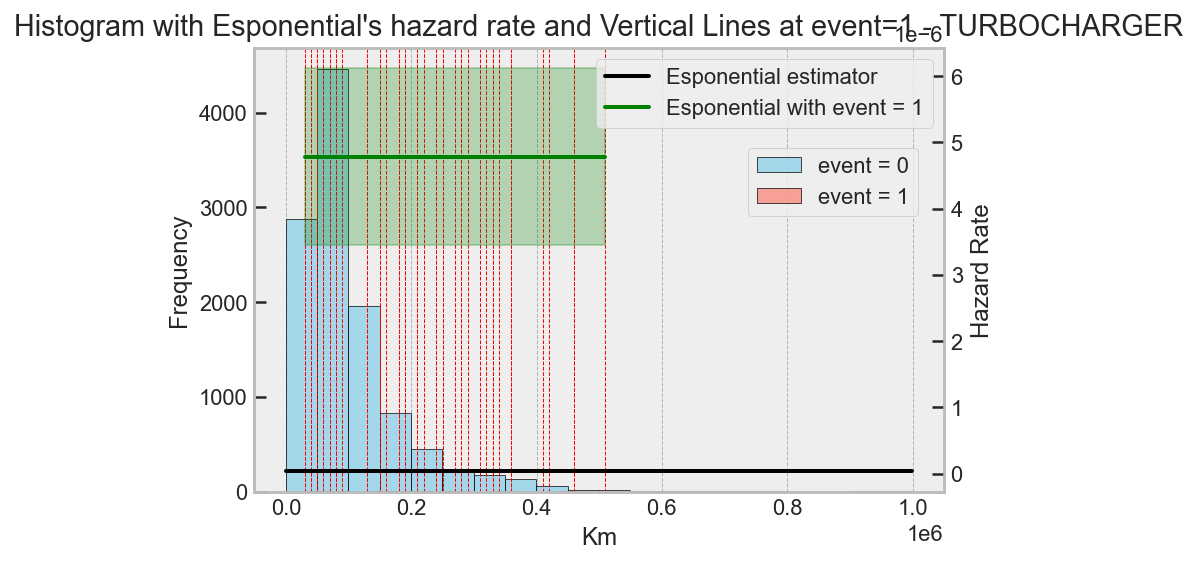

In [65]:
from lifelines import ExponentialFitter

fig, ax1 = plt.subplots()
ax1.hist(X_turbo[X_turbo['event'] == 0]['km'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='event = 0')
ax1.hist(X_turbo[X_turbo['event'] == 1]['km'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='event = 1')
ax1.set_xlabel('Km')
ax1.set_ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.8))


x_values = X_turbo[X_turbo['event'] == 1]['km'].values
for x in x_values:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=0.5)



# Kaplan-Meier survival curve on a secondary y-axis
ax2 = ax1.twinx()
epf = ExponentialFitter()
epf.fit(X_turbo['km'], event_observed=X_turbo["event"])
epf.plot_hazard(ax=ax2, color='black', label = "Esponential estimator")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "lower right")


# Additional plot
X_train_1 = X_turbo[X_turbo.event == 1].copy()
epf2 = ExponentialFitter()
epf2.fit(X_train_1["km"], event_observed=X_train_1["event"])
epf2.plot_hazard(ax=ax2, color='green', label = "Esponential with event = 1")
ax2.set_ylabel('Hazard Rate')
ax2.legend(loc = "upper right")




plt.title('Histogram with Esponential\'s hazard rate and Vertical Lines at event=1 - TURBOCHARGER')
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
ax1.grid(False, which='both', axis='y')
ax2.grid(False, which='both', axis='y')
plt.tight_layout()
plt.show()


## COX-PH

In [67]:
# Last observation at km:
X_turbo[X_turbo.event==1].km.max()


510000.0

In [68]:
# Last observation at km_12:
X_turbo[X_turbo.event==0].km_12.max()


1602958.3333333335

<lifelines.CoxPHFitter: fitted with 11264 total observations, 11215 right-censored observations>
             duration col = 'km'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 11264
number of events observed = 49
   partial log-likelihood = -336.05
         time fit was run = 2024-06-27 13:48:01 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
contract_market   1.44       4.21       0.36             0.74             2.14                 2.09                 8.46

                  cmp to    z      p   -log2(p)
covariate                                      
contract_market     0.00 4.04 <0.005      14.17
---
Concordance = 0.60
Partial AIC = 674.09
log-likelihood ratio test = 19.12 on 1 df
-log2(p) of ll-ratio test = 16.31

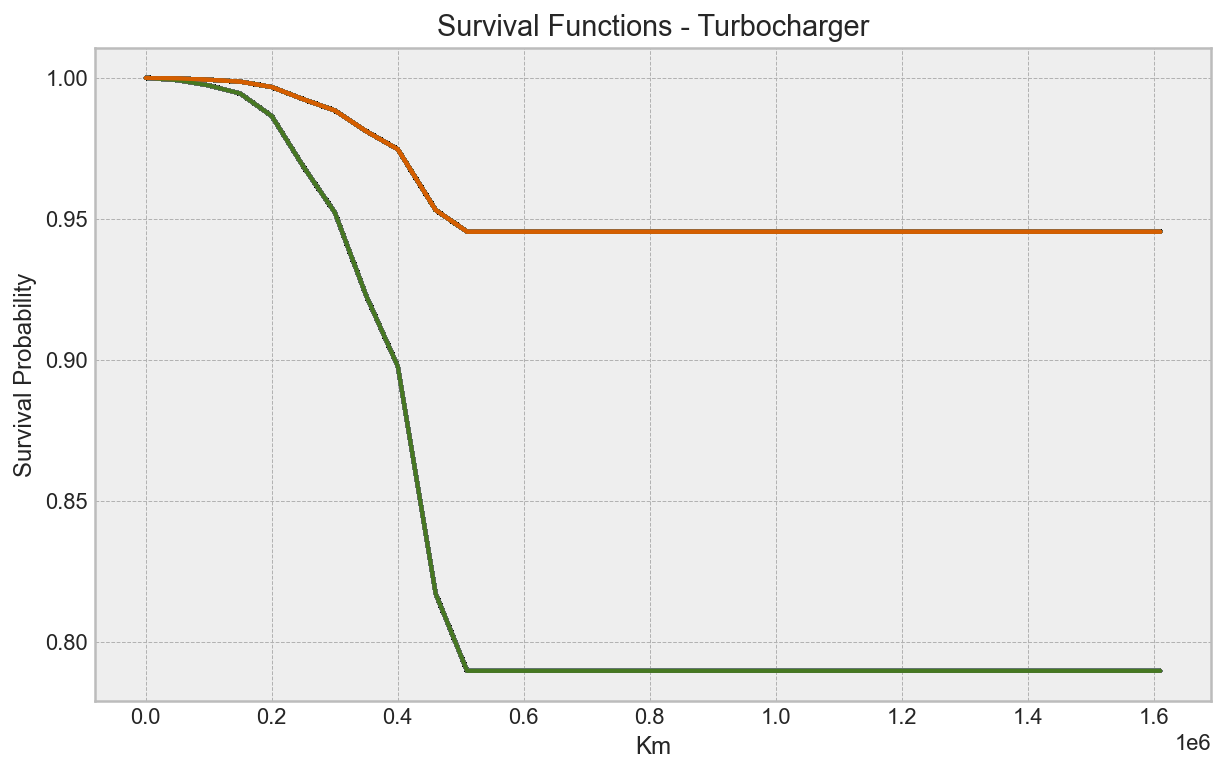

In [69]:
###################################################################
############################ COX-PH MODEL #########################
###################################################################

# Here we are interested in understanding the effect of the covariate on the HAZARD RATE
# No functional assumptions are made about the shape of the Hazard Function;
# instead, functional-form assumptions are made about the effects of the covariates alone.

# Regardless of the values covariates, all subjects share the same baseline hazard λₒ.
# (thereafter, adjustments are made based on the covariates)


from lifelines import CoxPHFitter


cph_t = CoxPHFitter()

X_t = X_turbo.drop(columns=["unique_vehicle_id", "km_12", "mis", "part_number"])
cph_t.fit(X_t, duration_col='km', event_col='event', formula = "contract_market")

cph_t.print_summary()


TIME_BINS = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 460000, 510000, 560000, 610000, 660000,
            710000, 760000, 810000, 860000, 910000, 960000, 1010000, 1060000, 1110000, 1160000, 1210000, 1260000,
            1310000, 1360000, 1410000, 1460000, 1510000, 1560000, 1610000]

# X_turbo[X_turbo.event==0].km_12.max()   # for this dataset, the max is 1.6M km
# TIME_BINS = np.arange(0, max_km + 50000, 50000, dtype="int")

survival_predictions_t = cph_t.predict_survival_function(X_t[X_t.event==0], times=TIME_BINS)

# Plot the survival functions
plt.figure(figsize=(10, 6))
for i in range(survival_predictions_t.shape[1]):
    plt.plot(survival_predictions_t.index, survival_predictions_t.iloc[:, i], label=f'Observation {i+1}')
plt.title('Survival Functions - Turbocharger')
plt.xlabel('Km')
plt.ylabel('Survival Probability')
plt.show()


In [70]:
survival_predictions_t.T.drop_duplicates()


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
0,1.000,0.999,0.997,0.994,0.986,0.969,0.952,0.923,0.898,0.817,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790,0.790
1,1.000,1.000,0.999,0.999,0.997,0.992,0.988,0.981,0.975,0.953,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945,0.945


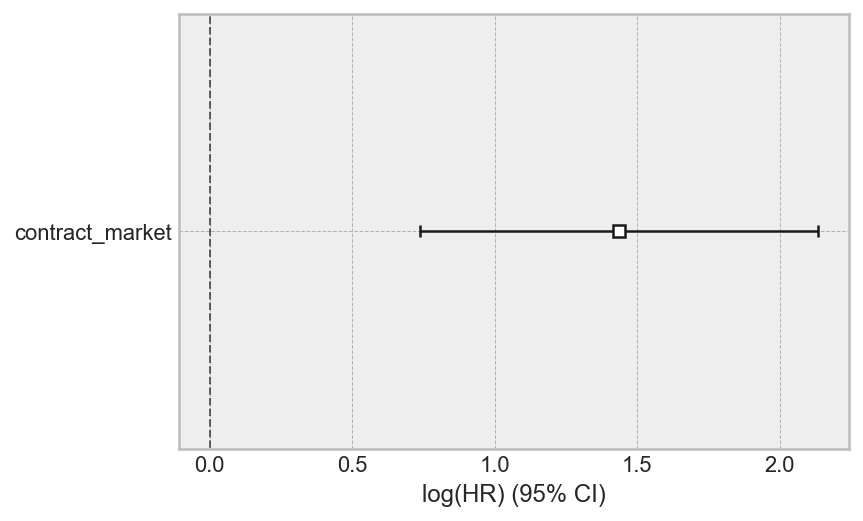

covariate
contract_market   1.438
Name: coef, dtype: float64


In [71]:
cph_t.plot()
plt.show()
print(cph_t.params_)


<AxesSubplot:>

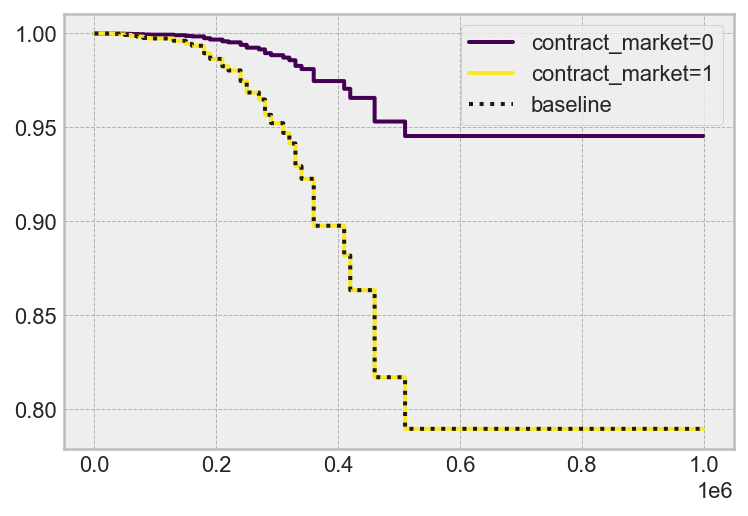

In [72]:
# What the survival curves look like as we vary a single covariate while holding everything else equal?

cph_t.plot_partial_effects_on_outcome(covariates='contract_market', values=[0, 1], cmap='viridis')


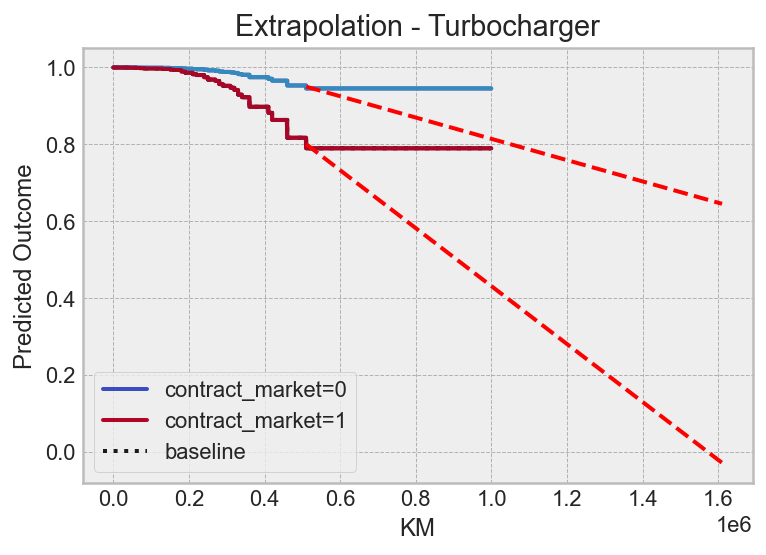

Contract market = 0 0.6450295742063197
Contract market = 1 -0.029481276316541738


In [73]:
############# EXTRAPOLATION #############

# The curve stops at 510K km, since there are no more observations with event = 1
# In order to escape the lack of data, we could (linearly, in this case) EXTRAPOLATE

ax_t = cph_t.plot_partial_effects_on_outcome(covariates='contract_market', values=[0, 1], cmap='coolwarm')


# Data points from the plot contract_market = 0
lines = ax_t.get_lines()
x_data_0 = lines[0].get_xdata()
y_data_0 = lines[0].get_ydata()

# Data points from the plot contract_market = 1
x_data_1 = lines[1].get_xdata()
y_data_1 = lines[1].get_ydata()


# Range of interest (410K-460K in this case)
end_range = X_turbo[X_turbo.event==1].km.max()

# Data points in the range of interest
selected_indices_0 = (x_data_0 >= end_range - 20000) & (x_data_0 <= end_range)
x_selected_0 = x_data_0[selected_indices_0]
y_selected_0 = y_data_0[selected_indices_0]

# contract_market = 1
selected_indices_1 = (x_data_1 >= end_range - 60000) & (x_data_1 <= end_range)
x_selected_1 = x_data_1[selected_indices_1]
y_selected_1 = y_data_1[selected_indices_1]


# Linear fit
coefficients_0 = np.polyfit(x_selected_0, y_selected_0, 1)
linear_model_0 = np.poly1d(coefficients_0)

coefficients_1 = np.polyfit(x_selected_1, y_selected_1, 1)
linear_model_1 = np.poly1d(coefficients_1)


# New values for extrapolation
max_km = X_turbo[X_turbo.event==0].km_12.max() + 10000
x_new = np.arange(end_range, max_km, 50000)
y_new_0 = linear_model_0(x_new)
y_new_1 = linear_model_1(x_new)



plt.plot(x_data_0, y_data_0, label='Original Data')
plt.plot(x_new, y_new_0, '--', label='Extrapolated Data', color='red')
plt.plot(x_data_1, y_data_1, label='Original Data')
plt.plot(x_new, y_new_1, '--', label='Extrapolated Data', color='red')
plt.xlabel('KM')
plt.ylabel('Predicted Outcome')
plt.title("Extrapolation - Turbocharger")

plt.show()


# Probabilities at the last km (mis + 12)
print("Contract market = 0", y_new_0.min())
print("Contract market = 1", y_new_1.min())



   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 11264 total observations, 11215 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
contract_market km              5.70 0.02      5.88
                rank            0.26 0.61      0.72



1. Variable 'contract_market' failed the non-proportional test: p-value is 0.0169.

   Advice: with so few unique values (only 2), you can include `strata=['contract_market', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<AxesSubplot:xlabel='rank-transformed time\n(p=0.6070)'>,
  <AxesSubplot:xlabel='km-transformed time\n(p=0.0169)'>]]

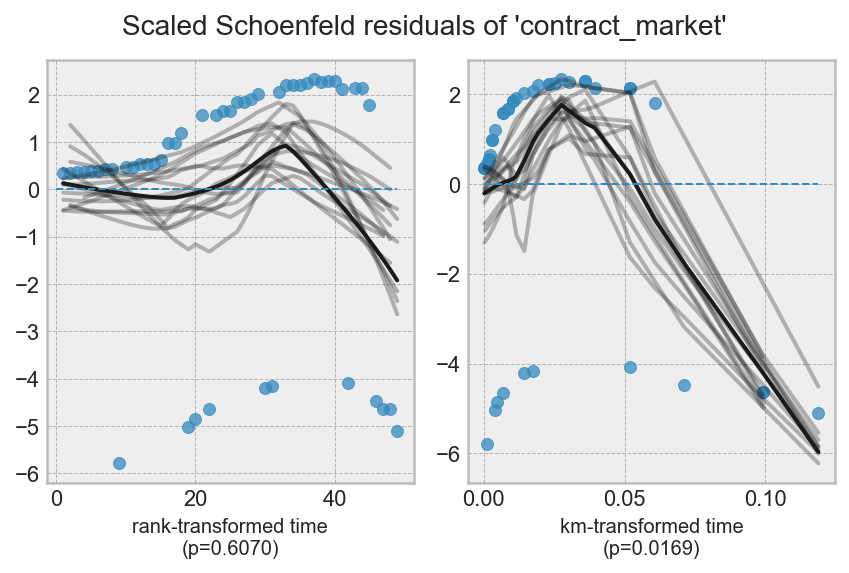

In [74]:
# Checking the proportional hazard assumption:
# (when using the Cox model, we are implicitly applying the proportional hazard assumption)

cph_t.check_assumptions(X_turbo, p_value_threshold=0.05, show_plots=True)


In [75]:
print(y_new_0.shape)
print(y_new_1.shape)
print(survival_predictions_t.T.drop_duplicates().shape)


(23,)
(23,)
(2, 33)


In [76]:
cox_working_df = survival_predictions_t.T.drop_duplicates().copy()
cox_working_df.iloc[0, 10:] = y_new_1
cox_working_df.iloc[1, 10:] = y_new_0

new_row = pd.Series(cox_working_df.columns).to_frame().T
new_row.columns = cox_working_df.columns
cox_working_df = pd.concat([new_row, cox_working_df], ignore_index=True)


In [77]:
cox_working_df


,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
0,0.000,50000.000,100000.000,150000.000,200000.000,250000.000,300000.000,350000.000,400000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000
1,1.000,0.999,0.997,0.994,0.986,0.969,0.952,0.923,0.898,0.817,0.800,0.763,0.725,0.687,0.649,0.612,0.574,0.536,0.499,0.461,0.423,0.385,0.348,0.310,0.272,0.235,0.197,0.159,0.121,0.084,0.046,0.008,-0.029
2,1.000,1.000,0.999,0.999,0.997,0.992,0.988,0.981,0.975,0.953,0.950,0.936,0.922,0.908,0.895,0.881,0.867,0.853,0.839,0.825,0.811,0.798,0.784,0.770,0.756,0.742,0.728,0.714,0.700,0.687,0.673,0.659,0.645


In [78]:
#### FUNCTION 1 ####
df2, df, working_df, TIME_BINS = survival_function_predictions_cox(X_turbo, cph_t)


In [81]:
for idx in range(len(df2)):
    if df2.loc[idx, "contract"]==1:
        df2.iloc[idx, 13:] = cox_working_df.iloc[1, :].values
    else:
        df2.iloc[idx, 13:] = cox_working_df.iloc[2, :].values


In [82]:
for idx in range(len(df)):
    if np.isclose(df.iloc[idx, -1], 0.645, atol=0.001):
        df.iloc[idx, :] = cox_working_df.iloc[1, :].values
    else:
        df.iloc[idx, :] = cox_working_df.iloc[2, :].values


In [84]:
##### FUNCTION 2 #####

# PREDICTION MIS + 12  (INTERPOLATION)
df2_ = linear_interpolation(cox_working_df, df2)


In [85]:
df2_[["failure_flag_80", "failure_flag_70", "failure_flag_60", "failure_flag_50",
      "failure_flag_40", "failure_flag_30", "failure_flag_20"]].apply(pd.Series.value_counts)


,failure_flag_80,failure_flag_70,failure_flag_60,failure_flag_50,failure_flag_40,failure_flag_30,failure_flag_20
0,11168,11178,11190,11198,11201,11202,11207
1,47,37,25,17,14,13,8


In [86]:
###################################################################
############################ AFT MODEL ############################
###################################################################

from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = X_turbo["km"], event_observed = X_turbo["event"])

# Print AIC
print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)


The AIC value for LogLogisticFitter is 1697.9829028924362


In [87]:
# Implementation of the LogLogistic AFT Fitter
from lifelines import LogLogisticAFTFitter

np.random.seed(0)
aft_t = LogLogisticAFTFitter()

# Fit the model to the dataset
X_t = X_turbo.drop(columns = ["unique_vehicle_id", "km_12", "mis", "part_number"])
aft_t.fit_right_censoring(X_t, duration_col='km', event_col='event', formula= "contract_market",
                              show_progress=True)

aft_t.print_summary()
print("\n\nMEDIAN SURVIVAL TIME:", aft_t.median_survival_time_)
print("MEAN SURVIVAL TIME", aft_t.mean_survival_time_)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.074579453674852
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.074579453674852
       x: [ 1.456e+01 -2.274e-01  8.559e-01]
     nit: 15
     jac: [ 2.982e-04  2.111e-05 -1.050e-04]
    nfev: 15
    njev: 15


<lifelines.LogLogisticAFTFitter: fitted with 11264 total observations, 11215 right-censored observations>
             duration col = 'km'
                event col = 'event'
   number of observations = 11264
number of events observed = 49
           log-likelihood = -840.06
         time fit was run = 2024-06-27 13:50:13 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                               
alpha_ Intercept        14.56   2.10e+06       0.21            14.14            14.98             1.39e+06             3.19e+06
       contract_market  -0.57       0.57       0.16            -0.87            -0.26                 0.42                 0.77
beta_  Intercept         0.86       2.35       0.08             0.70             1.01                 2.01                 2.76

                         cmp to     z      p   -log2(p)
param  covariate                                       
alpha_ Intercept           0.00 68.48 <0.005        inf
       contract_market     0.00 -3.63 <0.005      11.80
beta_  Intercept           0.00 10.60 <0.005      84.77
---
Concordance = 0.60
AIC = 1686.13
log-likelihood ratio test = 13.86 on 1 df
-log2(p) of ll-ratio test = 12.31



MEDIAN SURVIVAL TIME: 1192753.69813761
MEAN SURVIVAL TIME 1637554.9900430606


<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

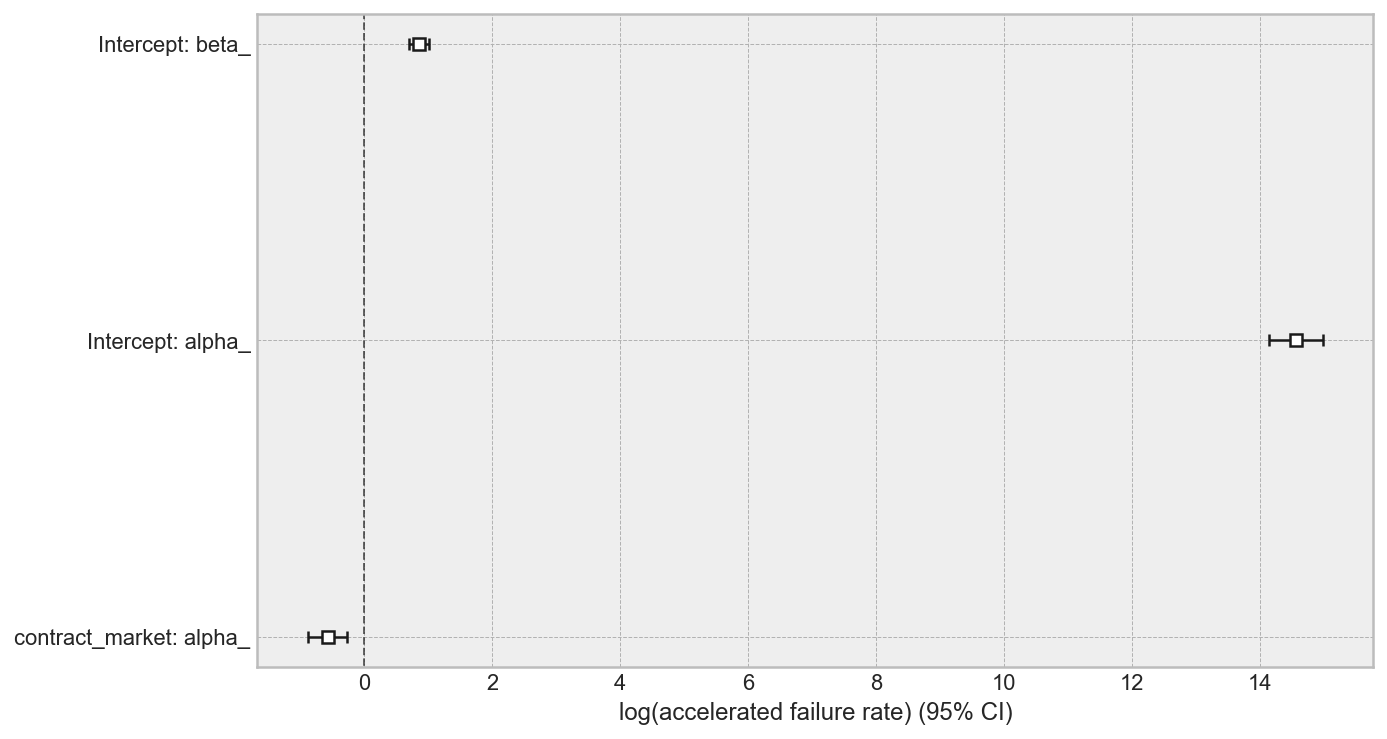

In [88]:
plt.subplots(figsize=(10, 6))
aft_t.plot()


Text(0, 0.5, 'Survival probability')

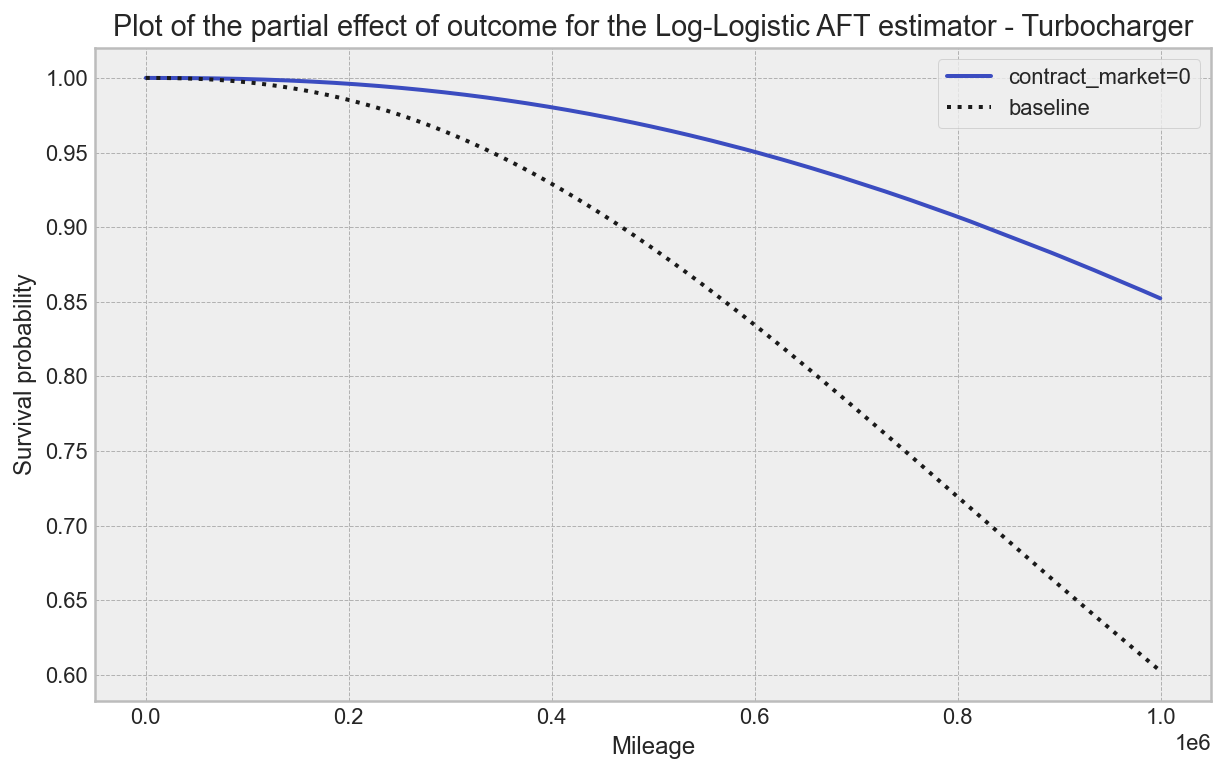

In [89]:
# HOW DOES SURVIVAL CHANGE WHEN WE CHANGE THE VALUES OF THE COVARIATES?
# (only contract_marketin in this case)
plt.subplots(figsize=(10, 6))
aft_t.plot_partial_effects_on_outcome("contract_market",
                                        range(0, 1),
                                        cmap='coolwarm')

plt.title("Plot of the partial effect of outcome for the Log-Logistic AFT estimator - Turbocharger")
plt.xlabel('Mileage')
plt.ylabel('Survival probability')


In [90]:
# PREDICTION OF THE SURVIVAL FUNCTION
# Given a new subject, we’d like to ask questions about their future survival. When are they likely to experience the event?

# This function simply returns the survival prediction at mis + 12 (for the max value)
df2_aft_t, df_aft_t, working_df_aft_t, TIME_BINS_t = survival_function_predictions(X_turbo, aft_t)


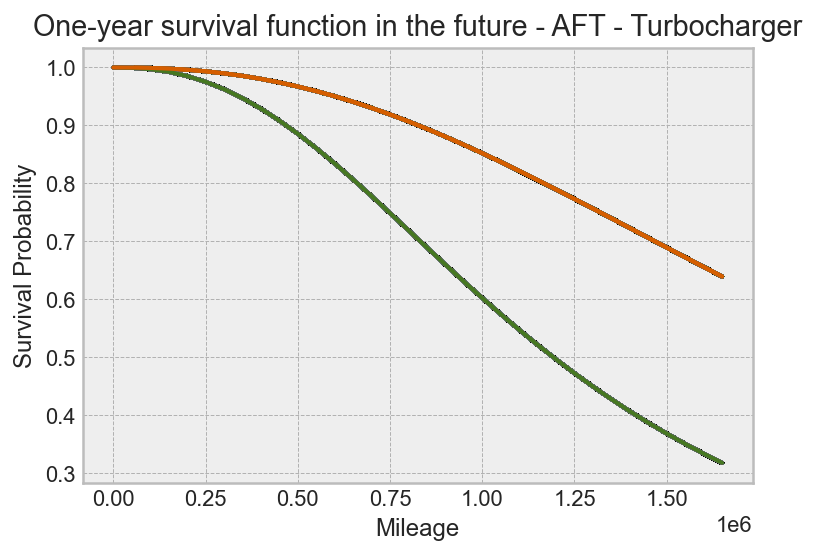

In [91]:
# PLOTTING THE SURVIVAL FUNCTION (one year in the future)
surv_func = aft_t.predict_survival_function(X_t[X_t.event == 0], times=TIME_BINS_t)
surv_func.plot(legend=False)

plt.title('One-year survival function in the future - AFT - Turbocharger')
plt.xlabel('Mileage')
plt.ylabel('Survival Probability')
plt.show()


In [92]:
# Given the fact that the model has just the variable "contract_market" to discriminate,
# it calculates only to groups (since the variable can be 1 or 0)
df2_aft_t.drop(columns=["unique_vehicle_id", "km", "km_12", "mis", "mis_plus_12", "failure_flag_80",
                "failure_flag_70", "failure_flag_60", "failure_flag_50", "failure_flag_40",
                "failure_flag_30", "failure_flag_20"]).drop_duplicates()


# Interpretation: groups with "FRANCE" as market are more likely to exeperience failures


,contract,0.0,50000.0,100000.0,150000.0,200000.0,250000.0,300000.0,350000.0,400000.0,450000.0,500000.0,550000.0,600000.0,650000.0,700000.0,750000.0,800000.0,850000.0,900000.0,950000.0,1000000.0,1050000.0,1100000.0,1150000.0,1200000.0,1250000.0,1300000.0,1350000.0,1400000.0,1450000.0,1500000.0,1550000.0,1600000.0,1650000.0
0,1,1.000,0.999,0.997,0.992,0.985,0.975,0.963,0.947,0.929,0.908,0.886,0.861,0.834,0.807,0.778,0.749,0.719,0.689,0.660,0.631,0.602,0.574,0.547,0.521,0.496,0.472,0.450,0.428,0.407,0.387,0.368,0.351,0.334,0.318
1,0,1.000,1.000,0.999,0.998,0.996,0.993,0.990,0.986,0.980,0.974,0.967,0.959,0.950,0.941,0.930,0.919,0.907,0.894,0.881,0.867,0.852,0.837,0.822,0.806,0.790,0.773,0.757,0.740,0.723,0.706,0.689,0.673,0.656,0.639


In [93]:
# PREDICTION MIS + 12
df2_aft_t_ = linear_interpolation(working_df_aft_t, df2_aft_t)


In [94]:
df2_aft_t_[["failure_flag_80", "failure_flag_70", "failure_flag_60", "failure_flag_50",
      "failure_flag_40", "failure_flag_30", "failure_flag_20"]].apply(pd.Series.value_counts)


,failure_flag_80,failure_flag_70,failure_flag_60,failure_flag_50,failure_flag_40,failure_flag_30,failure_flag_20
0,11182,11195,11201,11203,11211,11215.000,11215.000
1,33,20,14,12,4,NaN,NaN


In [95]:
###################################################################
###################### XBGSE (debiased) MODEL #####################
###################################################################

from xgbse import XGBSEDebiasedBCE
from xgbse.converters import convert_to_structured
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.metrics import make_scorer
from xgbse.metrics import (concordance_index, approx_brier_score)
from xgbse.extrapolation import extrapolate_constant_risk
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import display

 
# Better plots
set_matplotlib_formats('retina')
plt.style.use('bmh')

# Reproducibility
np.random.seed(42)


TIME_BINS_t = [
    0, 60000, 120000, 180000, 240000, 300000, 360000, 460000, 600000, 720000, 840000, 950000
]
 
xgbse_model_t = XGBSEDebiasedBCE(
    xgb_params={
        "aft_loss_distribution": "normal",
        "aft_loss_distribution_scale": 0.5,
        "booster": "dart",
        "colsample_bynode": 0.8,
        "eval_metric": "aft-nloglik",
        "learning_rate": 0.05,
        "max_depth": 5,
        "min_child_weight": 1,
        "objective": "survival:aft",
        "subsample": 0.8,
        "tree_method": "hist",
    }
)


X_train_t = X_turbo["contract_market"]
y_train_t = convert_to_structured(X_turbo["km"], X_turbo["event"])

X_test_t = X_turbo[X_turbo.event == 0]["contract_market"]
y_test_t = convert_to_structured(X_turbo[X_turbo.event == 0]["km_12"], X_turbo[X_turbo.event == 0]["event"])


xgbse_model_t.fit(X_train_t, y_train_t, time_bins=TIME_BINS_t)
y_pred_t = xgbse_model_t.predict(X_test_t)


# Extrapolation of the survival probabilities beyond the observed data (510K km)
last_km_t = X_turbo[X_turbo.event==1].km.max()
y_pred_extrapolated_t = extrapolate_constant_risk(y_pred_t.loc[:, :last_km_t], 1650000, 50000)


Average Brier Score: 0.023253808270041396


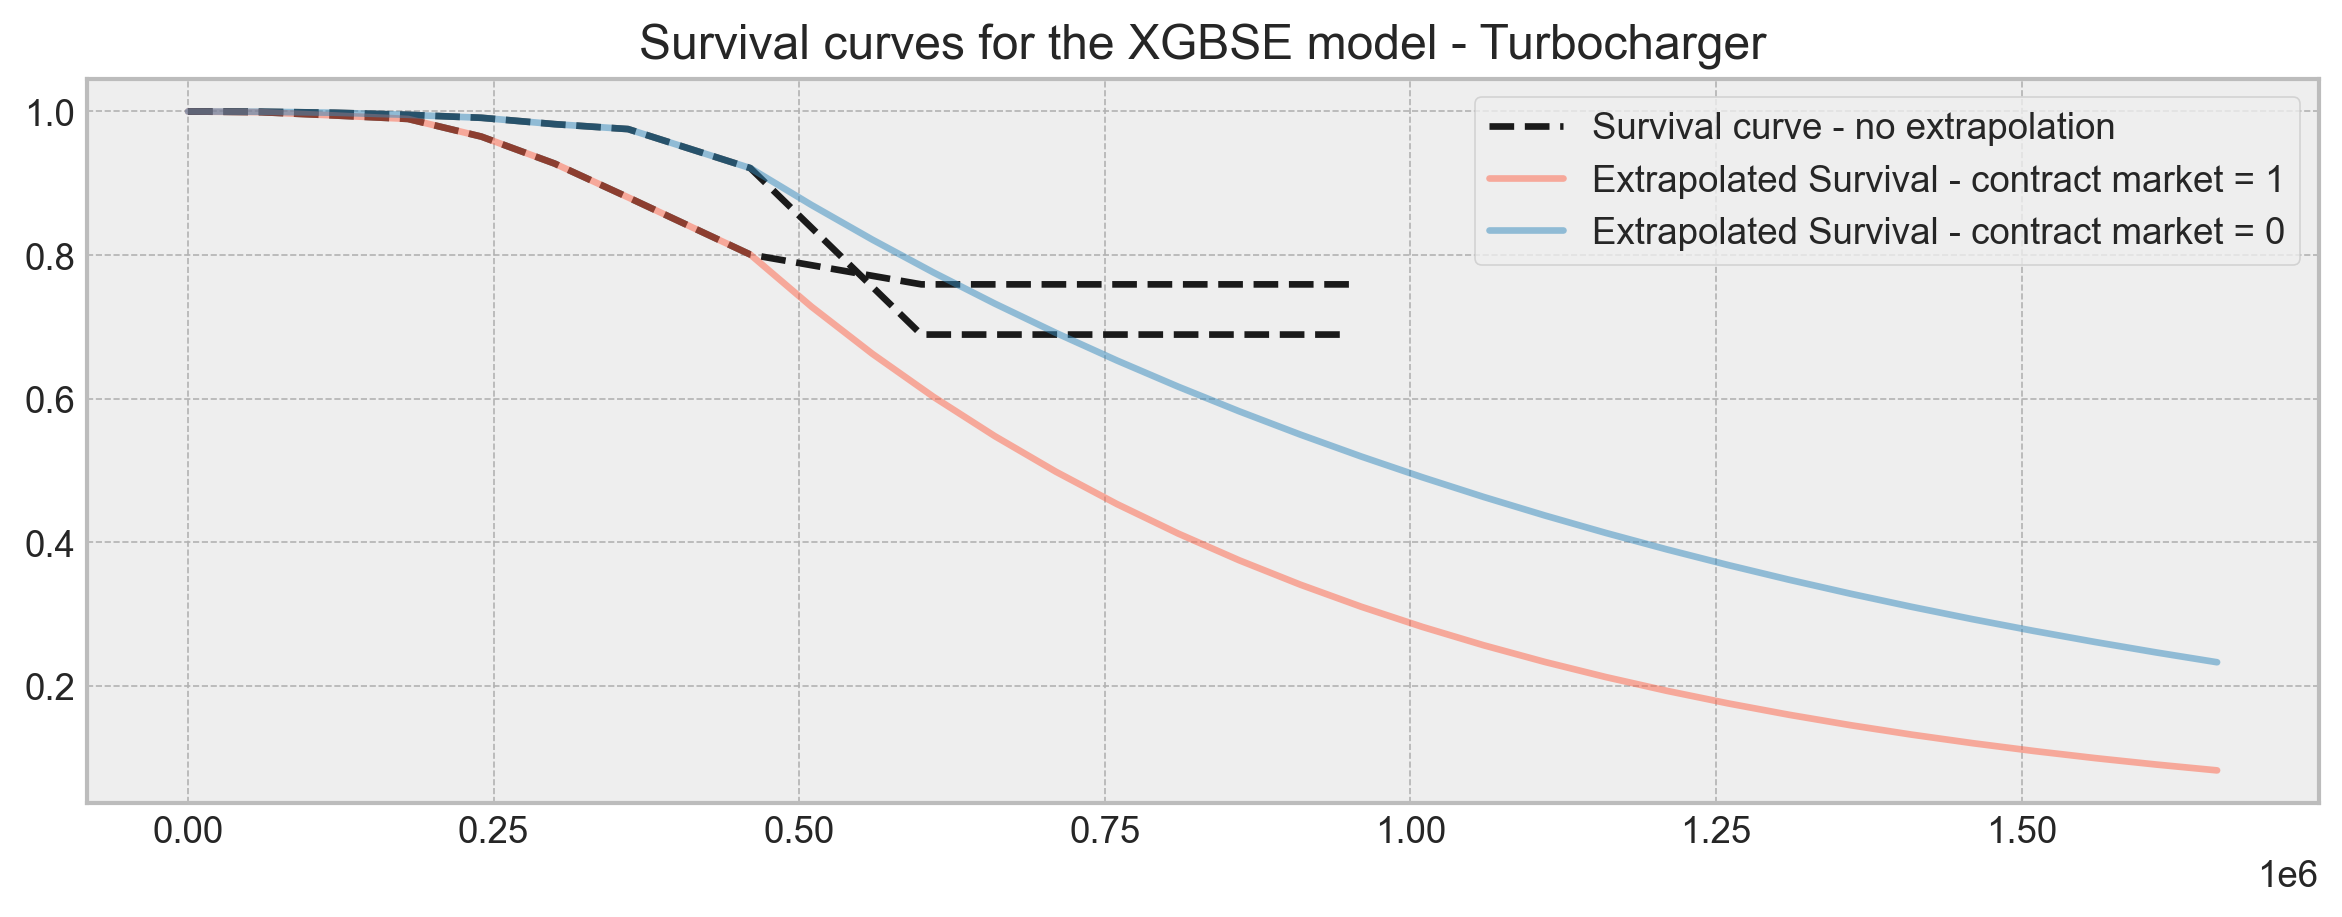

In [96]:
# plotting extrapolation
plt.figure(figsize=(12,4), dpi=120)
plt.plot(
    y_pred_t.columns,
    y_pred_t.iloc[0],
    'k--',
    label='Survival curve - no extrapolation'
)
plt.plot(
    y_pred_t.columns,
    y_pred_t.iloc[1],
    'k--'
)
plt.plot(
    y_pred_extrapolated_t.columns,
    y_pred_extrapolated_t.iloc[0],
    'tomato',
    alpha=0.5,
    label='Extrapolated Survival - contract market = 1'
)
plt.plot(
    y_pred_extrapolated_t.columns,
    y_pred_extrapolated_t.iloc[1],
    alpha=0.5,
    label='Extrapolated Survival - contract market = 0'
)
plt.title('Survival curves for the XGBSE model - Turbocharger')
plt.legend()


 
 
# Evaluation of model performances
bs = approx_brier_score(y_test_t, y_pred_t)
#ci = concordance_index(y_test, -y_pred, risk_strategy="precomputed")
#print(f'\n\nConcordance index: {ci}')
print(f'Average Brier Score: {bs}')

# Cross validation
#results = cross_val_score(xgbse_model, X, y_structured, scoring = make_scorer(approx_brier_score))
#print(f"Cross validation (Brier Score metric): {results}")


In [97]:
# Computing concordance index:
X_test = X_turbo["contract_market"]
y_true = convert_to_structured(X_turbo["km_12"], X_turbo["event"])

xgbse_model_t.fit(X_train_t, y_train_t, time_bins=TIME_BINS_t)

y_pred = xgbse_model_t.predict(X_test)
y_pred_extrapolated = extrapolate_constant_risk(y_pred.loc[:, :last_km_t], 1650000, 50000)


In [98]:
ci = concordance_index(y_true, y_pred_extrapolated, risk_strategy="mean")
print(f"The concordance index estimate is: {ci}")


The concordance index estimate is: 0.6041920579506566


In [99]:
# PREPARATION FOR THE XGBSE THRESHOLD DATASET
working_df_xgbse = y_pred_extrapolated.drop_duplicates().copy()
y_pred_extrapolated2 = y_pred_extrapolated.copy()

new_row = pd.Series(working_df_xgbse.columns).to_frame().T
new_row.columns = working_df_xgbse.columns
working_df_xgbse = pd.concat([new_row, working_df_xgbse], ignore_index=True)


y_pred_extrapolated2.insert(0, "unique_vehicle_id", 0)
y_pred_extrapolated2.insert(1, "km", 0)
y_pred_extrapolated2.insert(2, "mis", 0)
y_pred_extrapolated2.insert(3, "km_12", 0)
y_pred_extrapolated2.insert(4, "contract", 0)
y_pred_extrapolated2.insert(5, "mis_plus_12", 0)

y_pred_extrapolated2.insert(6, "failure_flag_80", 0)
y_pred_extrapolated2.insert(7, "failure_flag_70", 0)
y_pred_extrapolated2.insert(8, "failure_flag_60", 0)
y_pred_extrapolated2.insert(9, "failure_flag_50", 0)
y_pred_extrapolated2.insert(10, "failure_flag_40", 0)
y_pred_extrapolated2.insert(11, "failure_flag_30", 0)
y_pred_extrapolated2.insert(12, "failure_flag_20", 0)


np.random.seed(42)
y_pred_extrapolated2.loc[:, "contract"] = np.where(
    np.isclose(y_pred_extrapolated2.iloc[:, -1], 0.037, rtol=0, atol=.001),
    1, 0
)

y_pred_extrapolated2.loc[:, "unique_vehicle_id"] = X_turbo["unique_vehicle_id"].reset_index(drop=True)
y_pred_extrapolated2.loc[:, "km"] = X_turbo["km"].reset_index(drop=True)
y_pred_extrapolated2.loc[:, "mis"] = X_turbo["mis"].reset_index(drop=True)
y_pred_extrapolated2.loc[:, "km_12"] = y_pred_extrapolated2.loc[:, "km"] + y_pred_extrapolated2.loc[:, "km"] * 12 / y_pred_extrapolated2.loc[:, "mis"]


In [100]:
working_df_xgbse


,0,60000,120000,180000,240000,300000,360000,460000,510000,560000,610000,660000,710000,760000,810000,860000,910000,960000,1010000,1060000,1110000,1160000,1210000,1260000,1310000,1360000,1410000,1460000,1510000,1560000,1610000,1660000
0,0.000,60000.000,120000.000,180000.000,240000.000,300000.000,360000.000,460000.000,510000.000,560000.000,610000.000,660000.000,710000.000,760000.000,810000.000,860000.000,910000.000,960000.000,1010000.000,1060000.000,1110000.000,1160000.000,1210000.000,1260000.000,1310000.000,1360000.000,1410000.000,1460000.000,1510000.000,1560000.000,1610000.000,1660000.000
1,1.000,0.999,0.994,0.990,0.965,0.927,0.880,0.801,0.728,0.662,0.602,0.548,0.498,0.453,0.412,0.375,0.341,0.310,0.282,0.256,0.233,0.212,0.193,0.175,0.160,0.145,0.132,0.120,0.109,0.099,0.090,0.082
2,1.000,1.000,0.998,0.995,0.991,0.982,0.975,0.921,0.870,0.821,0.776,0.732,0.692,0.653,0.617,0.582,0.550,0.519,0.490,0.463,0.437,0.413,0.390,0.368,0.348,0.328,0.310,0.293,0.276,0.261,0.246,0.233


In [102]:
# LINEAR INTERPOLATION
y_pred_extrapolated2_ = linear_interpolation(working_df_xgbse, y_pred_extrapolated2)


In [103]:
y_pred_extrapolated2_[["failure_flag_80", "failure_flag_70", "failure_flag_60", "failure_flag_50",
      "failure_flag_40", "failure_flag_30", "failure_flag_20"]].apply(pd.Series.value_counts)


,failure_flag_80,failure_flag_70,failure_flag_60,failure_flag_50,failure_flag_40,failure_flag_30,failure_flag_20
0,11193,11224,11243,11249,11251,11260,11264.000
1,71,40,21,15,13,4,NaN


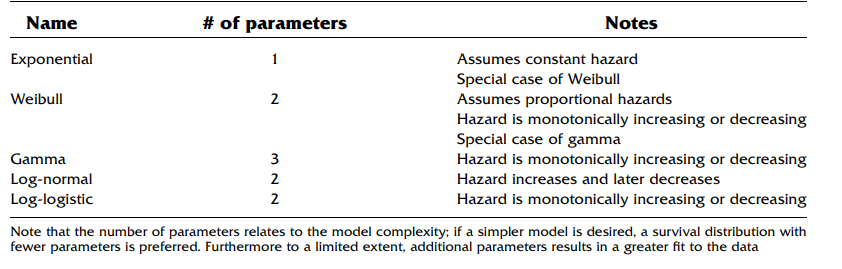